## 준비


In [ ]:
!pip install cliffs_delta
!pip install pymc3 arviz
!pip install koreanize-matplotlib
import koreanize_matplotlib

%config InlineBackend.figure_format = 'retina'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.4/11.4 MB 103.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 56.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import os
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats
from scipy.stats import (
    chi2_contingency,
    ttest_1samp,
    ttest_ind,
    mannwhitneyu,
    shapiro,
    levene,
    pearsonr,
    spearmanr,
    kendalltau,
    f_oneway,
    kruskal,
    beta,
)
from statsmodels.stats.proportion import proportions_ztest
import statsmodels.stats.api as sms
from cliffs_delta import cliffs_delta
import pymc as pm
import arviz as az
import kagglehub

## EDA

In [ ]:
df = pd.read_csv("cookie_cats.csv")

### 데이터의 정확한 확인을 위하여 다양한 분석 함수 사용

In [ ]:
def check_df(dataframe, head=5):
    print("########## Info #############")
    print(dataframe.info())
    print("\n########## Shape #############")
    print(dataframe.shape)
    print("\n########## Data Types #############")
    print(dataframe.dtypes)
    print("\n########## Null Values of Data #############")
    print(dataframe.isnull().sum())
    print("\n########## Describe of the Numerical Datas #############")
    print(dataframe.describe()[["sum_gamerounds"]].T)
    print("\n########## duplicated #############")
    print(dataframe.duplicated().sum())
    print("\n########## nunqiue #############")
    print(dataframe['userid'].nunique())

check_df(df)

########## Info #############
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB
None

########## Shape #############
(90189, 5)

########## Data Types #############
userid             int64
version           object
sum_gamerounds     int64
retention_1         bool
retention_7         bool
dtype: object

########## Null Values of Data #############
userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

########## Describe of the Numerical Datas #############
                  count       mean         std  min  2

### 게임 버전별 플레이 라운드 수 기초 통계 요약

In [ ]:
df.groupby('version')['sum_gamerounds'].agg(["count", "median", "mean", "std", "max"])

,count,median,mean,std,max
version,,,,,
gate_30,44700,17.0,52.456264,256.716423,49854
gate_40,45489,16.0,51.298776,103.294416,2640


### 게임 버전별 고유 사용자 수 비교

In [ ]:
df.groupby("version")[["userid"]].nunique()

,userid
version,
gate_30,44700
gate_40,45489


### 게임 버전별 사용자 분포 시각화


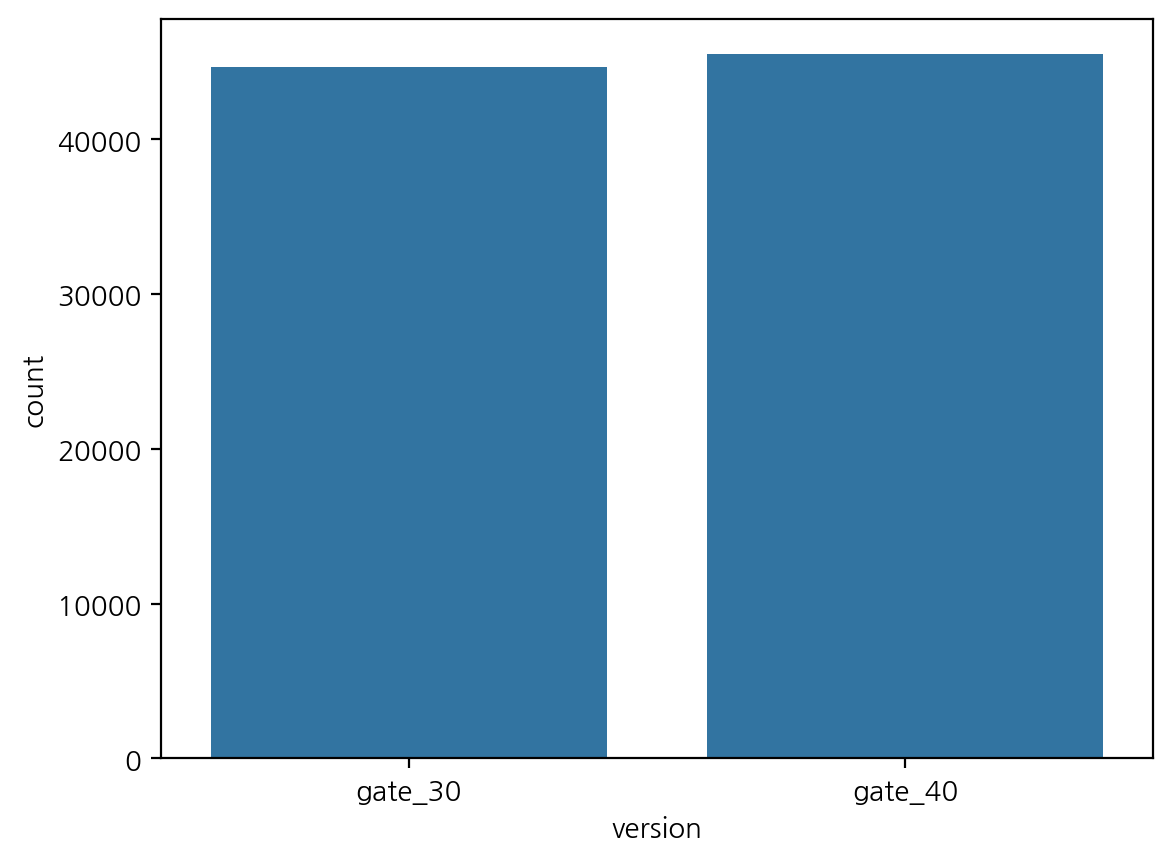

In [ ]:
sns.countplot(x="version",data=df);
plt.show()

### 게임 버전별 평균 플레이 라운드 수 비교

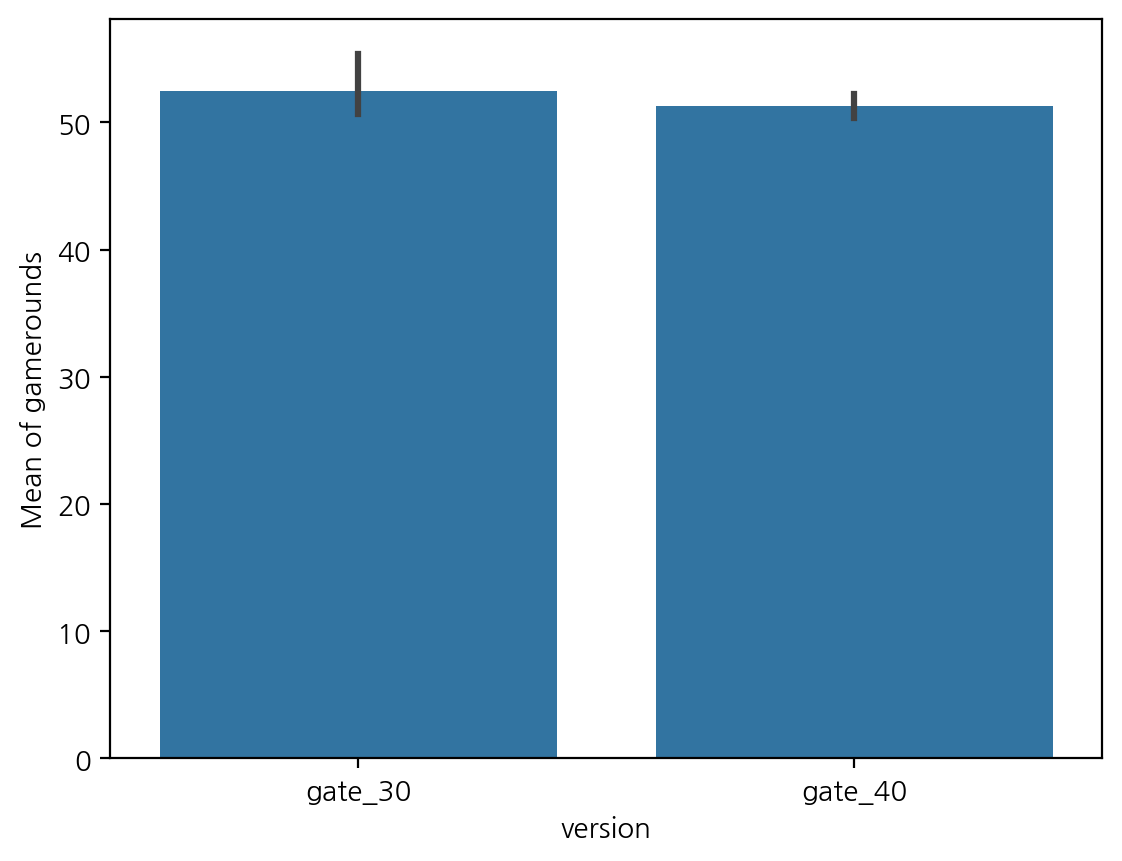

In [ ]:
sns.barplot(x='version', y='sum_gamerounds', data=df)

plt.ylabel("Mean of gamerounds");

### 게임 버전별 총 플레이 라운드 수 분포 비교 (이상치 포함)

In [ ]:
def plot_histograms(df, col, group_col, group_1, group_2):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    df[df[group_col] == group_1][col].hist(bins=50, color='skyblue', edgecolor='black')
    plt.title(f"{group_1} 그룹의 {col} 분포")
    plt.xlabel(col)
    plt.ylabel("빈도수")
    plt.subplot(1, 2, 2)
    df[df[group_col] == group_2][col].hist(bins=50, color='lightgreen', edgecolor='black')
    plt.title(f"{group_2} 그룹의 {col} 분포")
    plt.xlabel(col)
    plt.ylabel("빈도수")
    plt.tight_layout()
    plt.show()

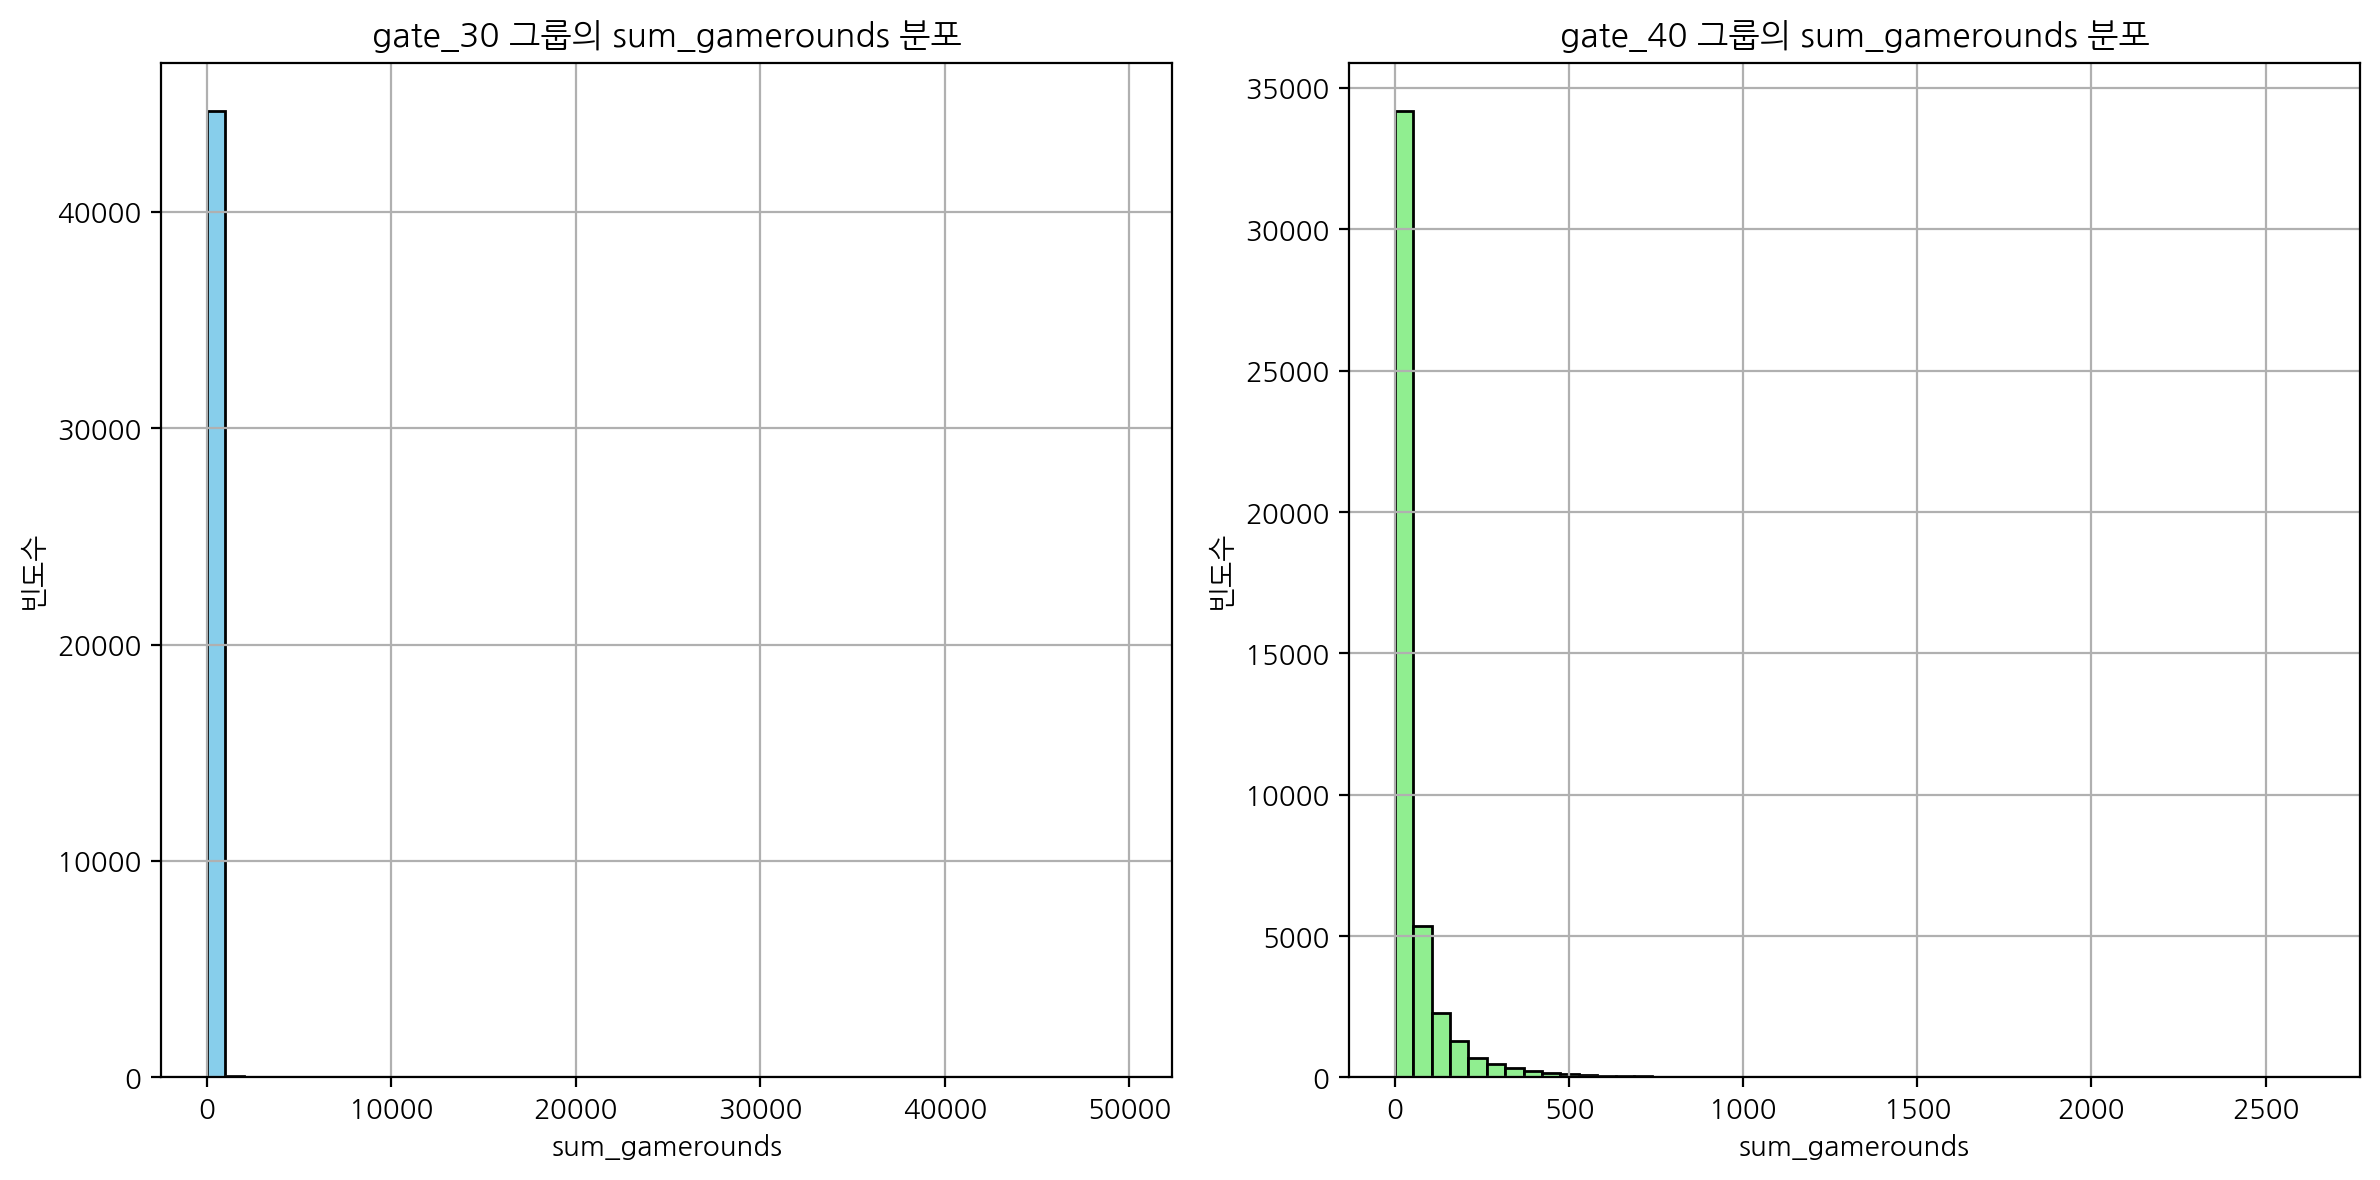

In [ ]:
plot_histograms(df, col="sum_gamerounds",
                group_col="version", group_1="gate_30",
                group_2="gate_40")

### 게임 버전별 총 플레이 라운드 수 분포 및 이상치 확인

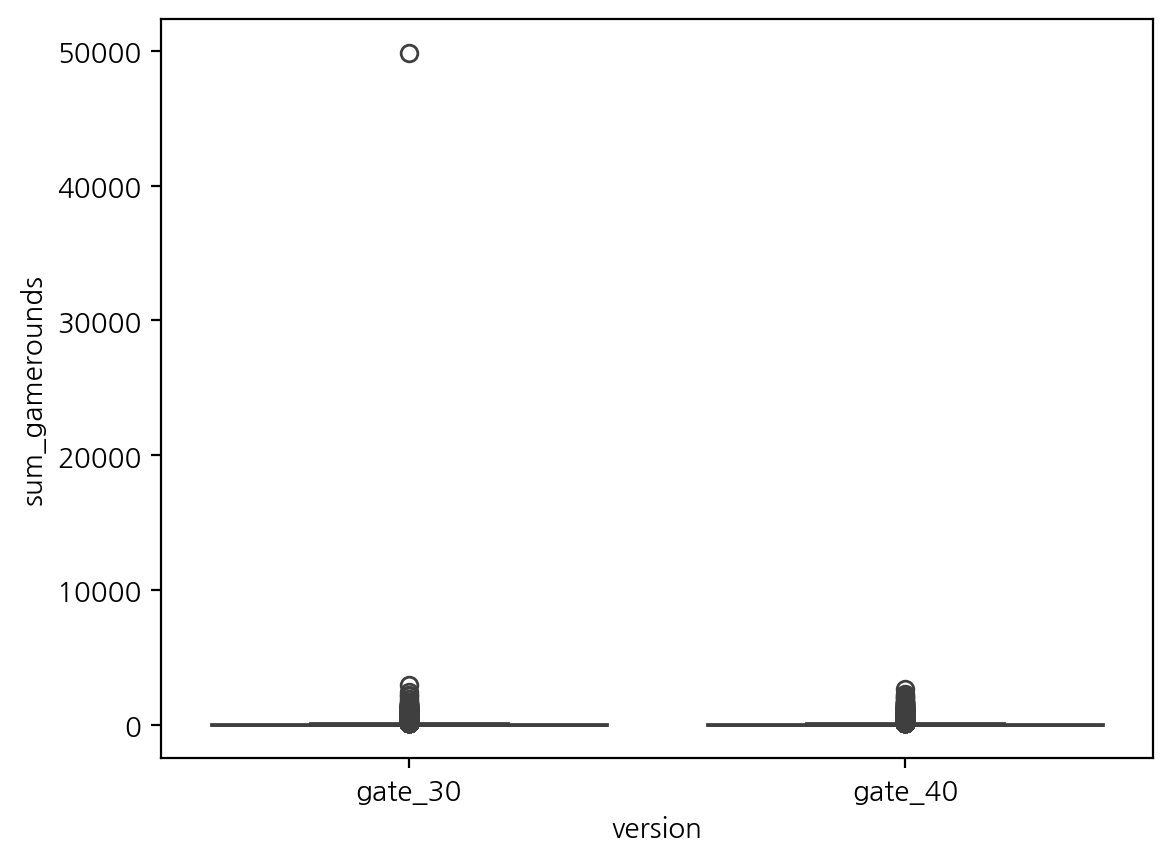

In [ ]:
sns.boxplot(data=df, x="version", y="sum_gamerounds");
plt.show();

### 총 플레이 라운드 수의 최대값 확인

In [ ]:
df['sum_gamerounds'].max()

49854

### 극단적인 플레이 라운드 수를 가진 사용자 확인

In [ ]:
df[df['sum_gamerounds'] == df['sum_gamerounds'].max()]

,userid,version,sum_gamerounds,retention_1,retention_7
57702,6390605,gate_30,49854,False,True


### 단일 극단값 제거 후 데이터 재구성

In [ ]:
df = df[df['sum_gamerounds'] != 49854]

### 극단값 제거 후 게임 버전별 총 플레이 라운드 수 분포

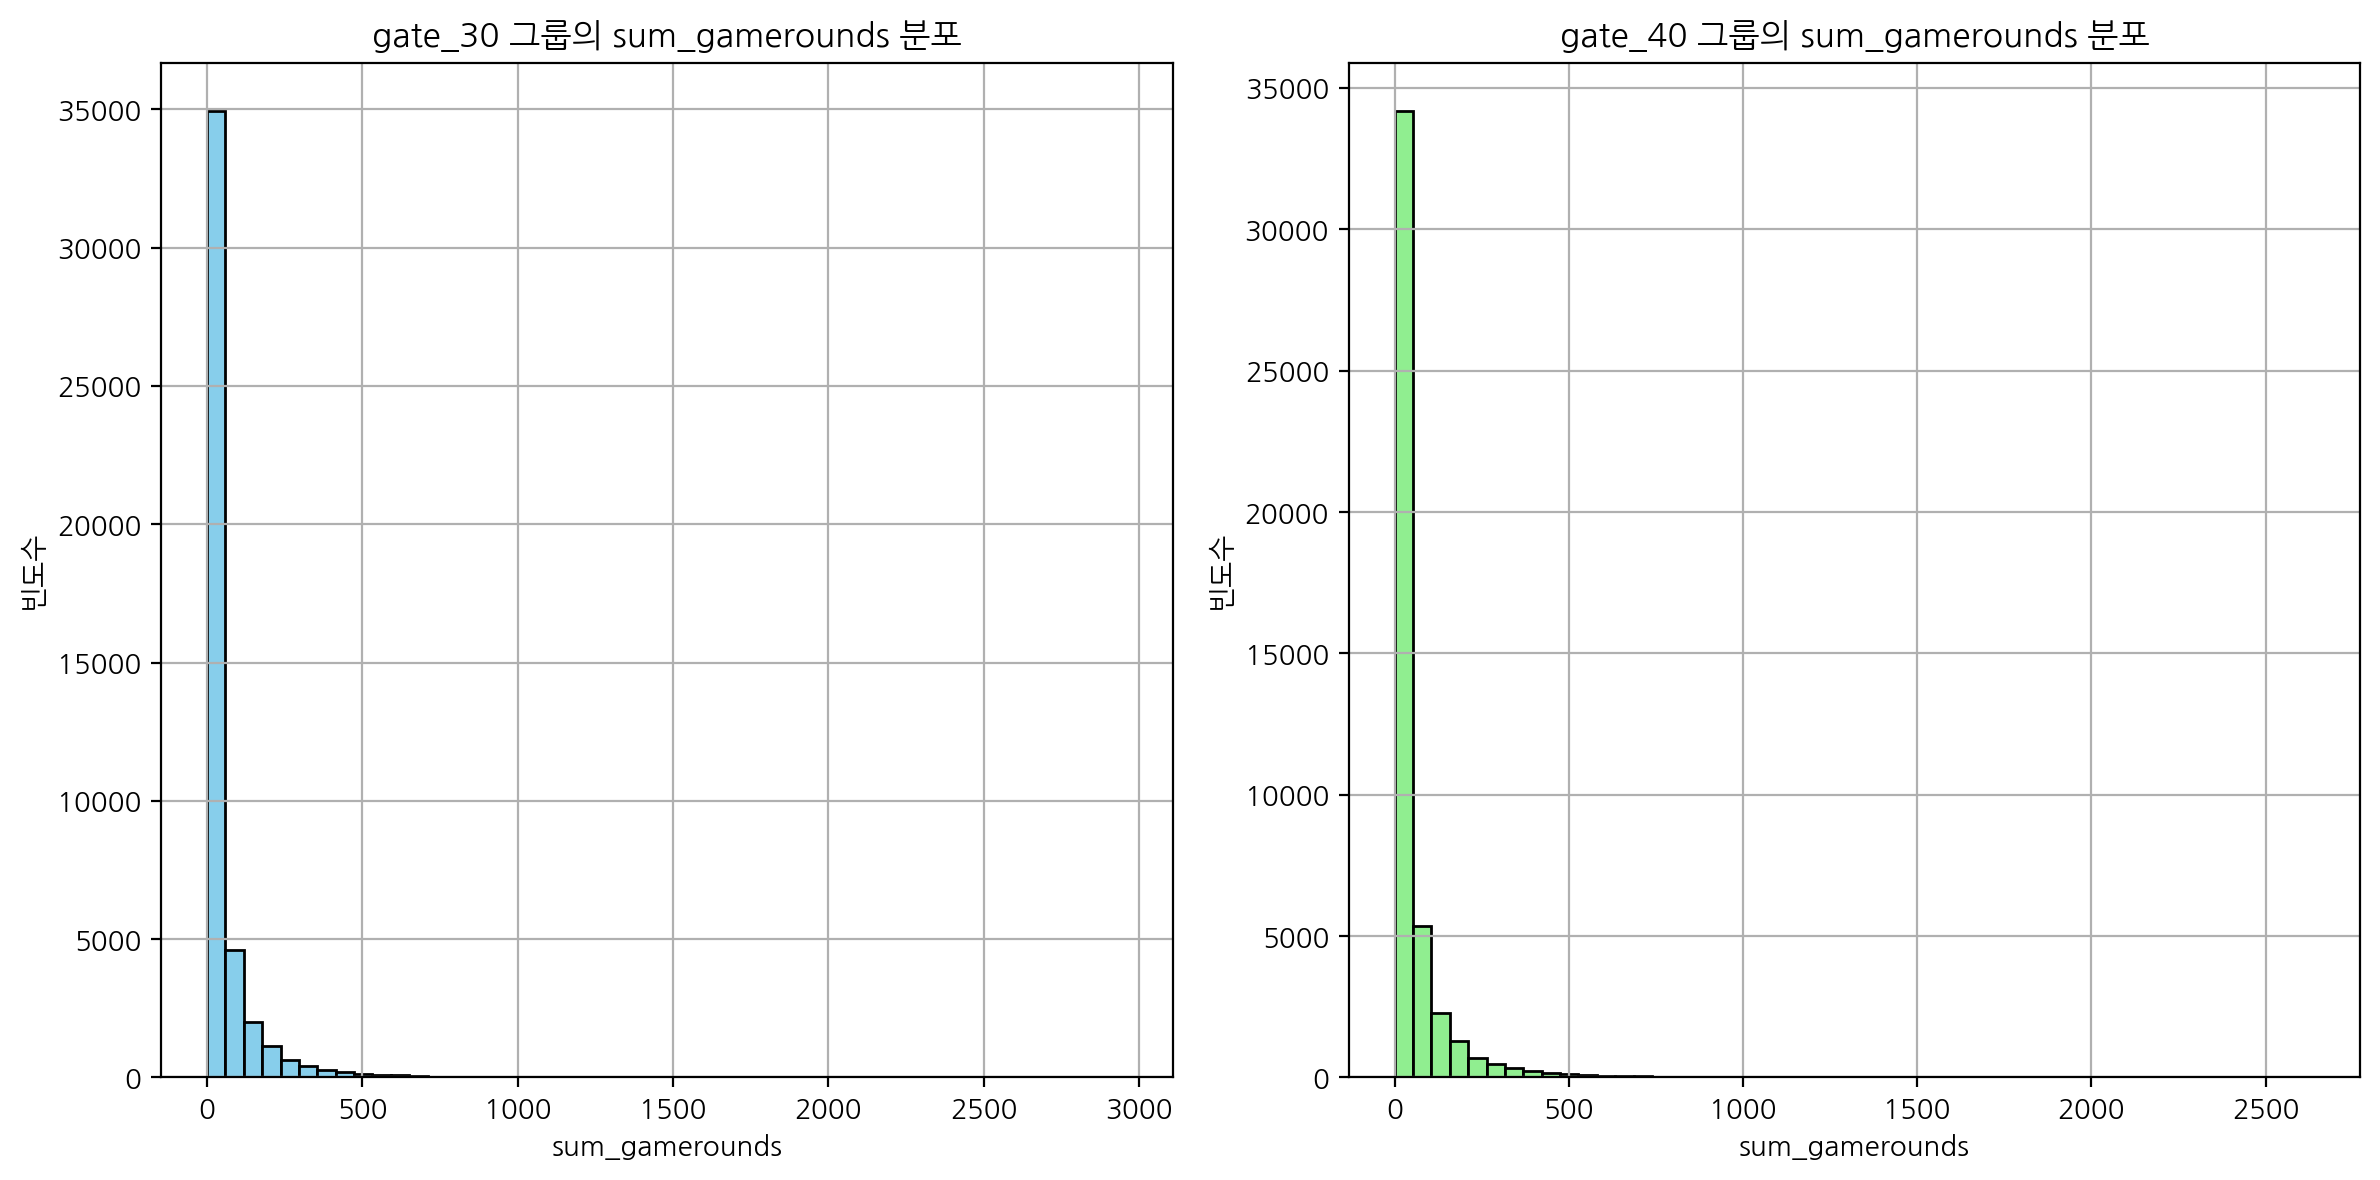

In [ ]:
plot_histograms(df, col="sum_gamerounds",
                group_col="version", group_1="gate_30",
                group_2="gate_40")

### 극단값 제거 후 게임 버전별 분포 비교

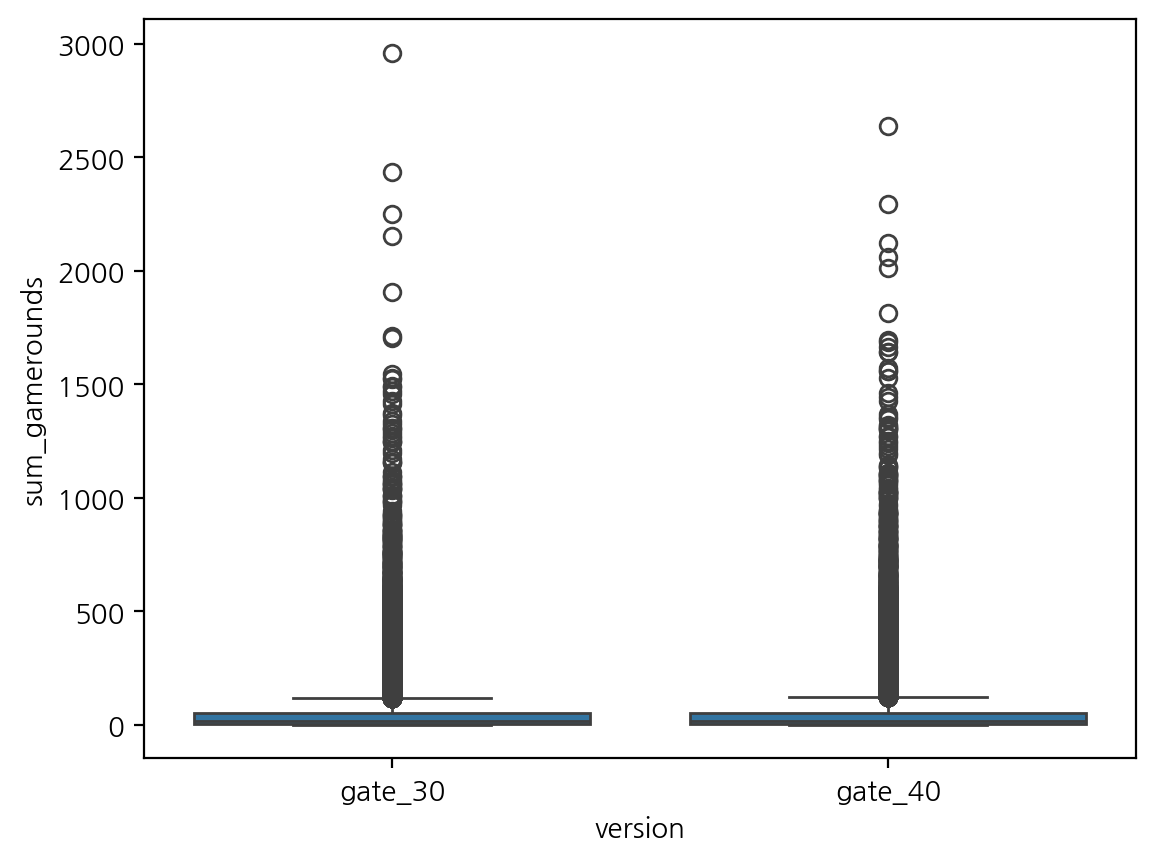

In [ ]:
sns.boxplot(data=df, x="version", y="sum_gamerounds");
plt.show();

### IQR 기반 이상치 범위 산출 (1.5×IQR 기준)

In [ ]:
Q1 = df['sum_gamerounds'].quantile(0.25)
Q3 = df['sum_gamerounds'].quantile(0.75)
IQR = Q3 - Q1

upper_bound = Q3 + 1.5 * IQR
lower_bound = Q1 - 1.5 * IQR

print(lower_bound, upper_bound)

-64.0 120.0


### 완화된 IQR 기준 이상치 범위 산출 (3×IQR 기준)

In [ ]:
Q1 = df['sum_gamerounds'].quantile(0.25)
Q3 = df['sum_gamerounds'].quantile(0.75)
IQR = Q3 - Q1

upper_bound = Q3 + 3 * IQR
lower_bound = Q1 - 3 * IQR

print(lower_bound, upper_bound)

-133.0 189.0


상·하위 분위수(1%–99%) 기준 트리밍 범위 산출

In [ ]:
lower = df['sum_gamerounds'].quantile(0.01)
upper = df['sum_gamerounds'].quantile(0.99)
df_trimmed = df[(df['sum_gamerounds'] >= lower) & (df['sum_gamerounds'] <= upper)]
print(lower, upper)

0.0 493.0


### 상·하위 분위수 기준 데이터 트리밍 적용

In [ ]:
df = df[(df['sum_gamerounds'] >= lower) & (df['sum_gamerounds'] <= upper)]

### 트리밍 후 게임 버전별 총 플레이 라운드 수 분포

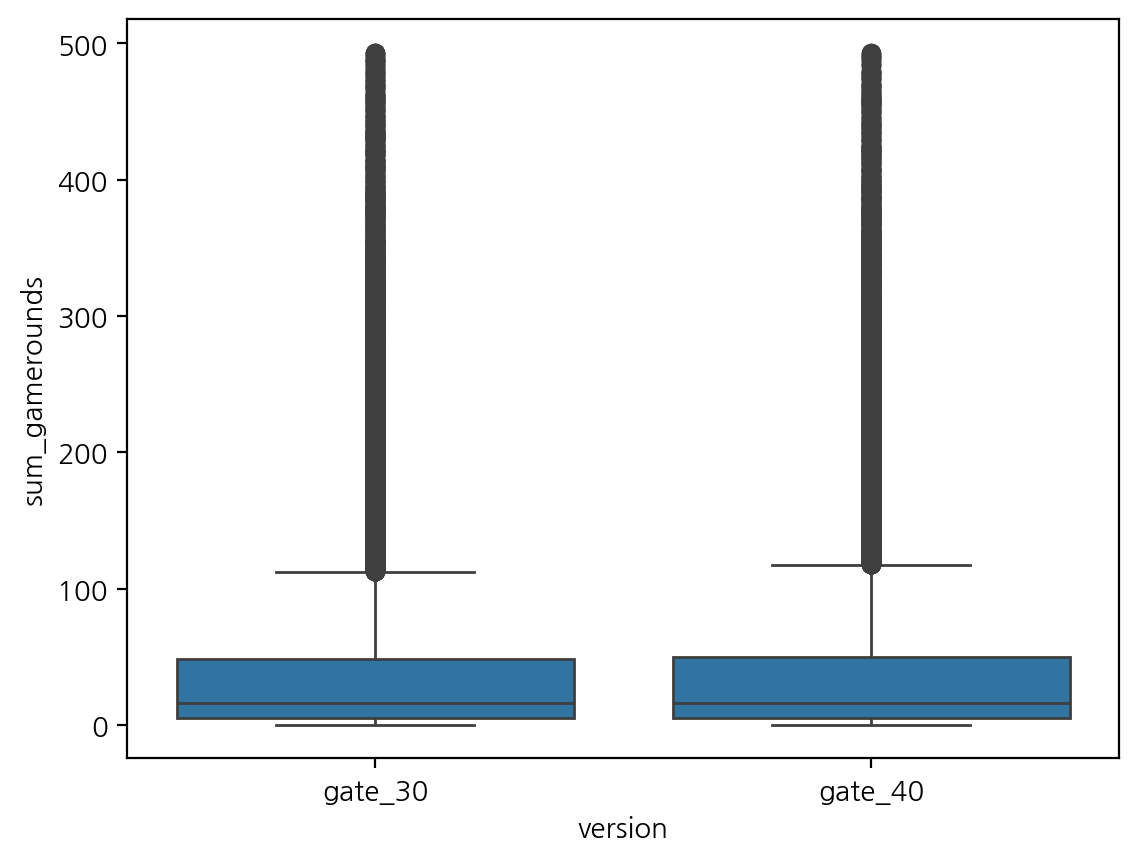

In [ ]:
sns.boxplot(data=df, x="version", y="sum_gamerounds");
plt.show();

### 총 플레이 라운드 수에 따른 사용자 분포

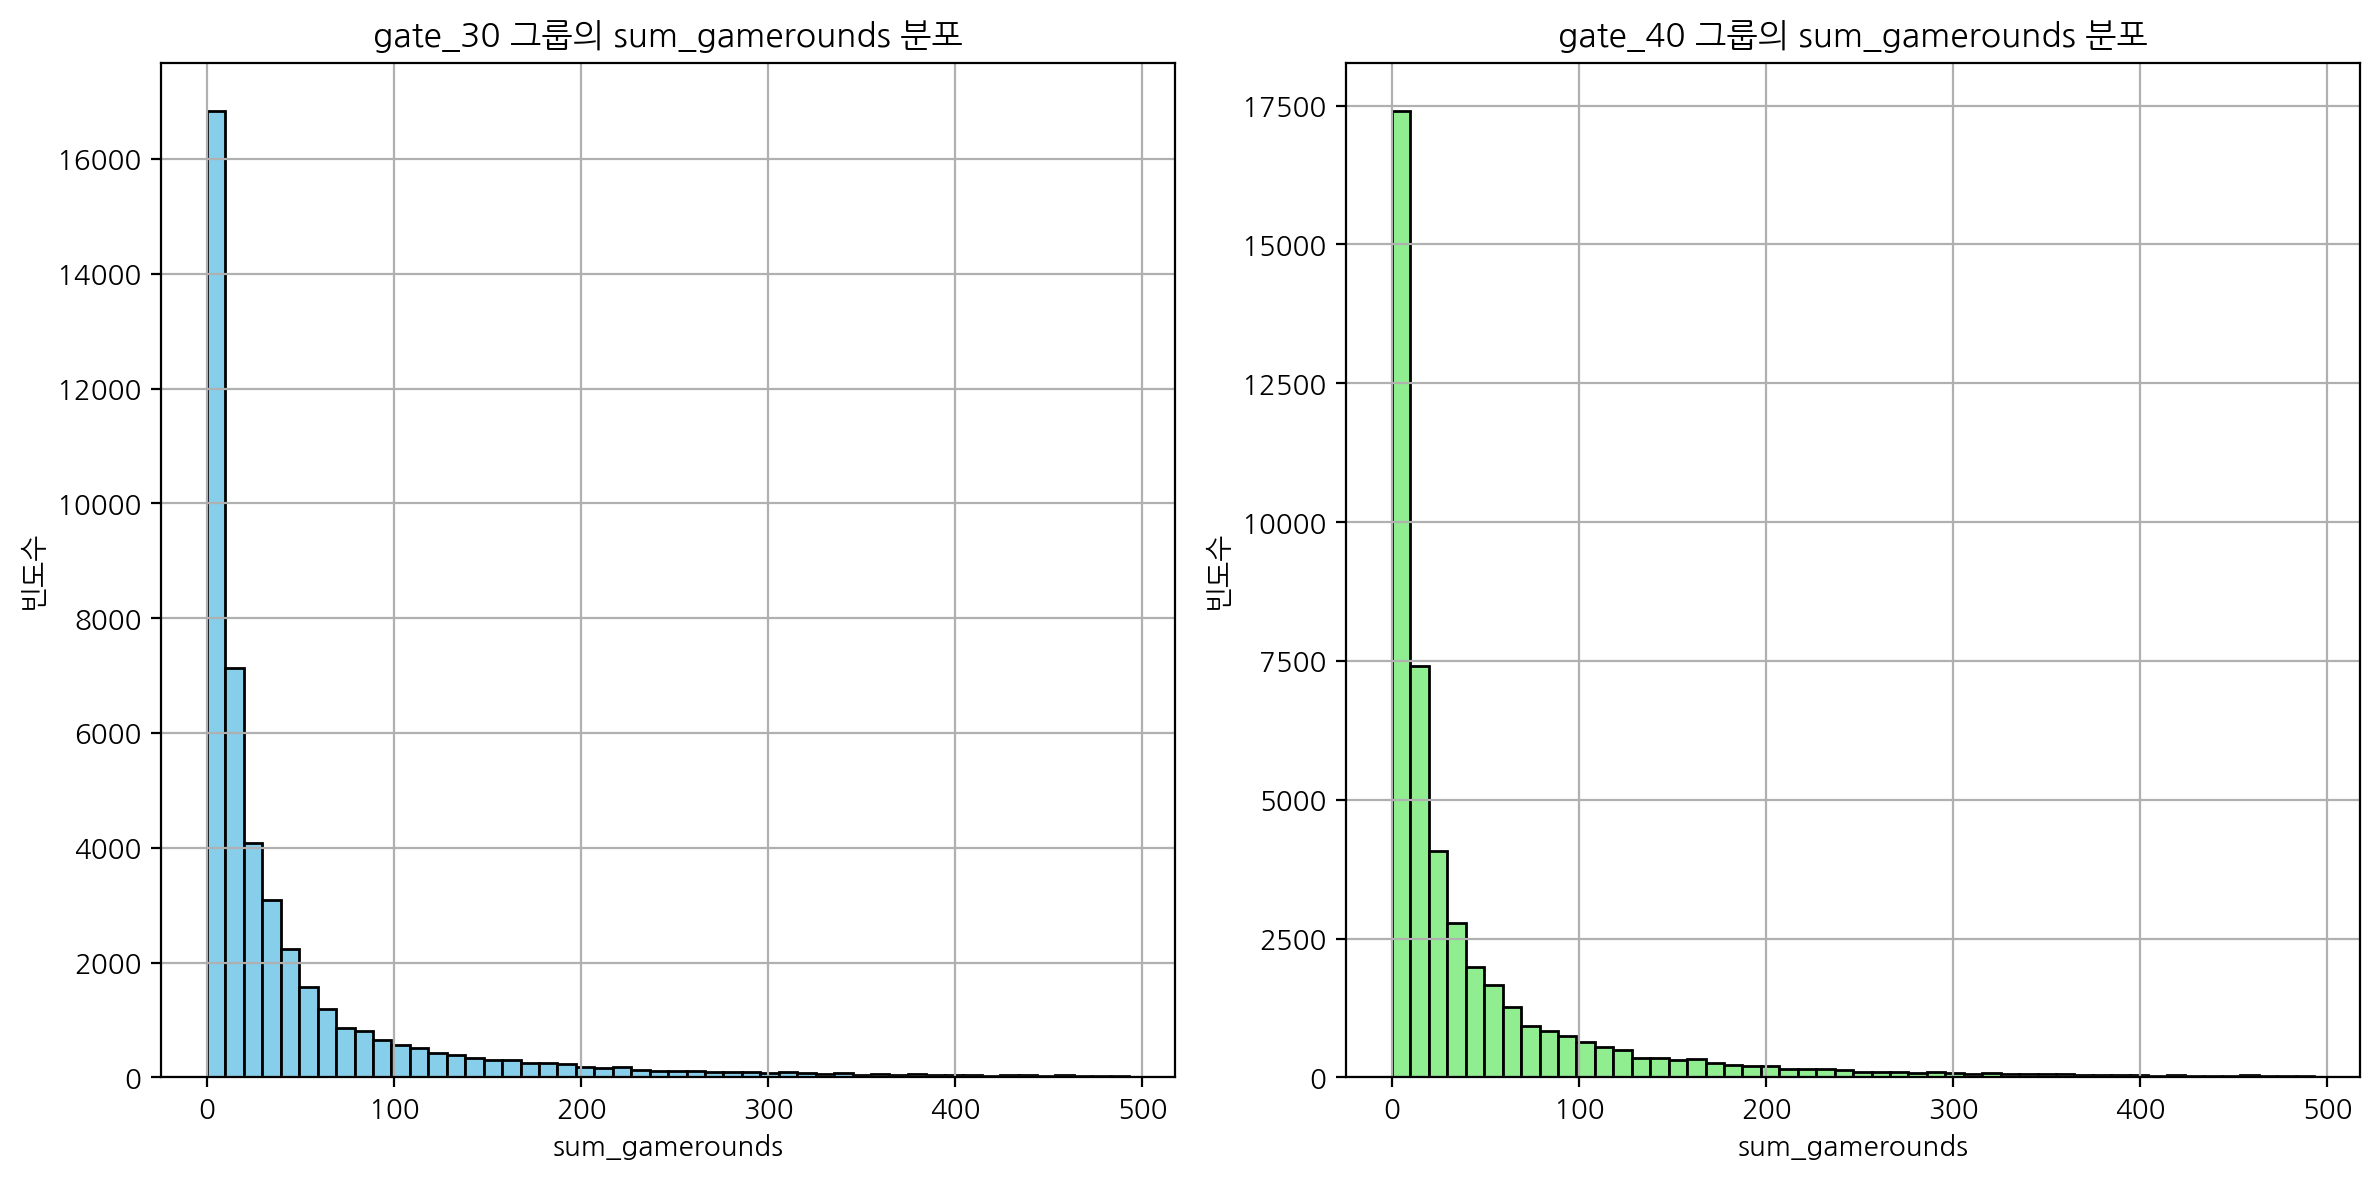

In [ ]:
plot_histograms(df, col="sum_gamerounds",
                group_col="version", group_1="gate_30",
                group_2="gate_40")

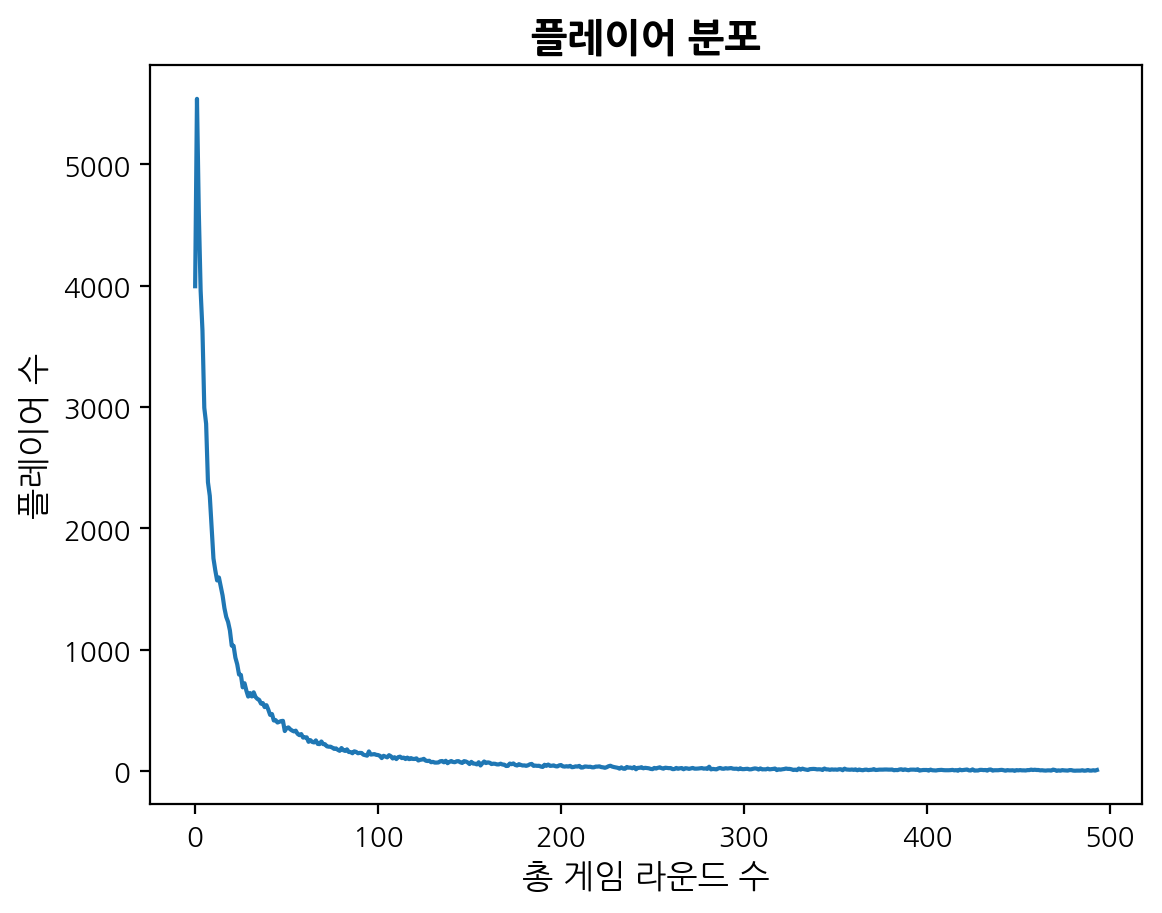

In [ ]:
plot_df = df.groupby("sum_gamerounds")["userid"].count()

ax = plot_df.plot()
plt.title("플레이어 분포", fontweight="bold", size=14)
plt.xlabel("총 게임 라운드 수", size=12)
plt.ylabel("플레이어 수", size=12)
plt.show()

### 플레이 라운드 수가 0인 사용자 규모 확인

In [ ]:
df[df["sum_gamerounds"]== 0]["userid"].count()

np.int64(3994)

### 전체 사용자 기준 리텐션 비율 요약

In [ ]:
df_retention = df[["retention_1","retention_7"]].mean()*100

print(f"1-day retention ratio: {round(df_retention[0],2)}% \
      \n7-days retention ratio: {round(df_retention[1],2)}%")

1-day retention ratio: 43.99%       
7-days retention ratio: 17.83%


/tmp/ipython-input-930388097.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"1-day retention ratio: {round(df_retention[0],2)}% \
/tmp/ipython-input-930388097.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  \n7-days retention ratio: {round(df_retention[1],2)}%")


### 게임 버전별 사용자 규모 및 리텐션 지표 요약

In [ ]:
df_retention_ab = df.groupby("version").agg({
    "userid": "count",
    "retention_1": "mean",
    "retention_7": "mean",
    "sum_gamerounds": "sum"
})

df_retention_ab

,userid,retention_1,retention_7,sum_gamerounds
version,,,,
gate_30,44254,0.442920,0.182537,1976494
gate_40,45037,0.436907,0.174190,1999480


### A/B 테스트를 위한 버전 라벨 변환

In [ ]:
df["version"] = np.where(df["version"] == "gate_30", "A", "B")
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,A,3,False,False
1,337,A,38,True,False
2,377,B,165,True,False
3,483,B,1,False,False
4,488,B,179,True,True


### A/B 그룹별 1일·7일 리텐션 평균 비교

In [ ]:
df.groupby("version")['retention_1'].mean(), df.groupby("version")['retention_7'].mean()

(version
 A    0.442920
 B    0.436907
 Name: retention_1, dtype: float64,
 version
 A    0.182537
 B    0.174190
 Name: retention_7, dtype: float64)

## Mann-Whitney U Test

### A/B 그룹 간 통계적 차이 검정을 위한 자동 검정 함수 정의

In [ ]:
def AB_Test(dataframe, group, target):
    groupA = dataframe[dataframe[group] == "A"][target]
    groupB = dataframe[dataframe[group] == "B"][target]

    normalA = shapiro(groupA)[1] > 0.05
    normalB = shapiro(groupB)[1] > 0.05

    if normalA and normalB:
        homogeneity = levene(groupA, groupB)[1] > 0.05

        if homogeneity:
            p_value = ttest_ind(groupA, groupB, equal_var=True)[1]
            test_type = "Parametric (T-test, Homogeneous)"
        else:
            p_value = ttest_ind(groupA, groupB, equal_var=False)[1]
            test_type = "Parametric (T-test, Heterogeneous)"
    else:
        p_value = mannwhitneyu(groupA, groupB)[1]
        test_type = "Non-Parametric (Mann-Whitney U)"

    result = "Reject H0" if p_value < 0.05 else "Fail to Reject H0"
    comment = "A/B groups are different!" if result == "Reject H0" else "A/B groups are similar!"

    summary = pd.DataFrame({
        "Test Type": [test_type],
        "p-value": [p_value],
        "AB Hypothesis": [result],
        "Comment": [comment]
    })

    return summary


In [ ]:
AB_Test(dataframe=df, group = "version", target = "sum_gamerounds")

/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 44254.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 45037.
  res = hypotest_fun_out(*samples, **kwds)


,Test Type,p-value,AB Hypothesis,Comment
0,Non-Parametric (Mann-Whitney U),0.04789,Reject H0,A/B groups are different!


## Bootstrapping

### 리텐션 비율의 부트스트랩 재표본 생성

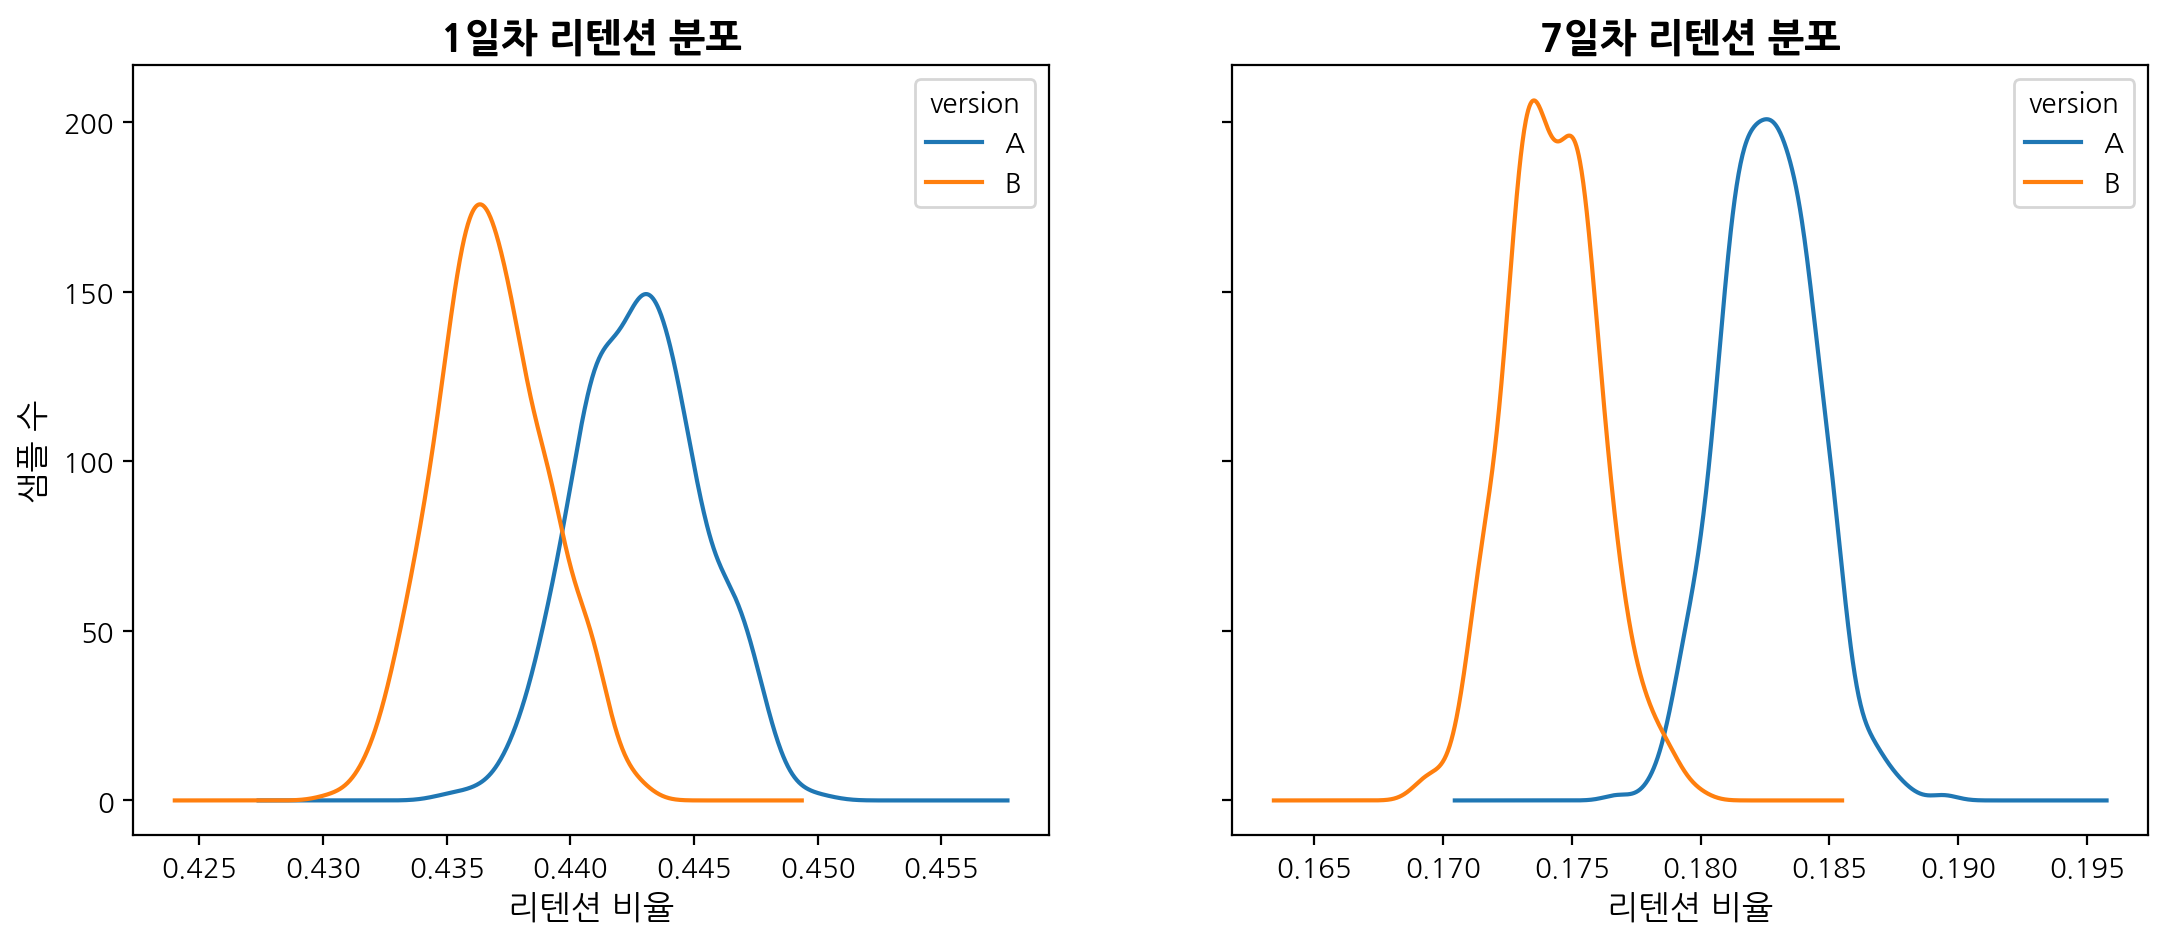

In [ ]:
boot_1d = []
boot_7d = []

for i in range(500):
    boot_mean_1 = df.sample(frac=1, replace=True).groupby('version')['retention_1'].mean()
    boot_mean_7 = df.sample(frac=1, replace=True).groupby('version')['retention_7'].mean()
    boot_1d.append(boot_mean_1)
    boot_7d.append(boot_mean_7)

boot_1d = pd.DataFrame(boot_1d)
boot_7d = pd.DataFrame(boot_7d)

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(13, 5))

boot_1d.plot.kde(ax=ax1)
ax1.set_xlabel("리텐션 비율", size=12)
ax1.set_ylabel("샘플 수", size=12)
ax1.set_title("1일차 리텐션 분포", fontweight="bold", size=14)

boot_7d.plot.kde(ax=ax2)
ax2.set_xlabel("리텐션 비율", size=12)
ax2.set_title("7일차 리텐션 분포", fontweight="bold", size=14)

plt.show()

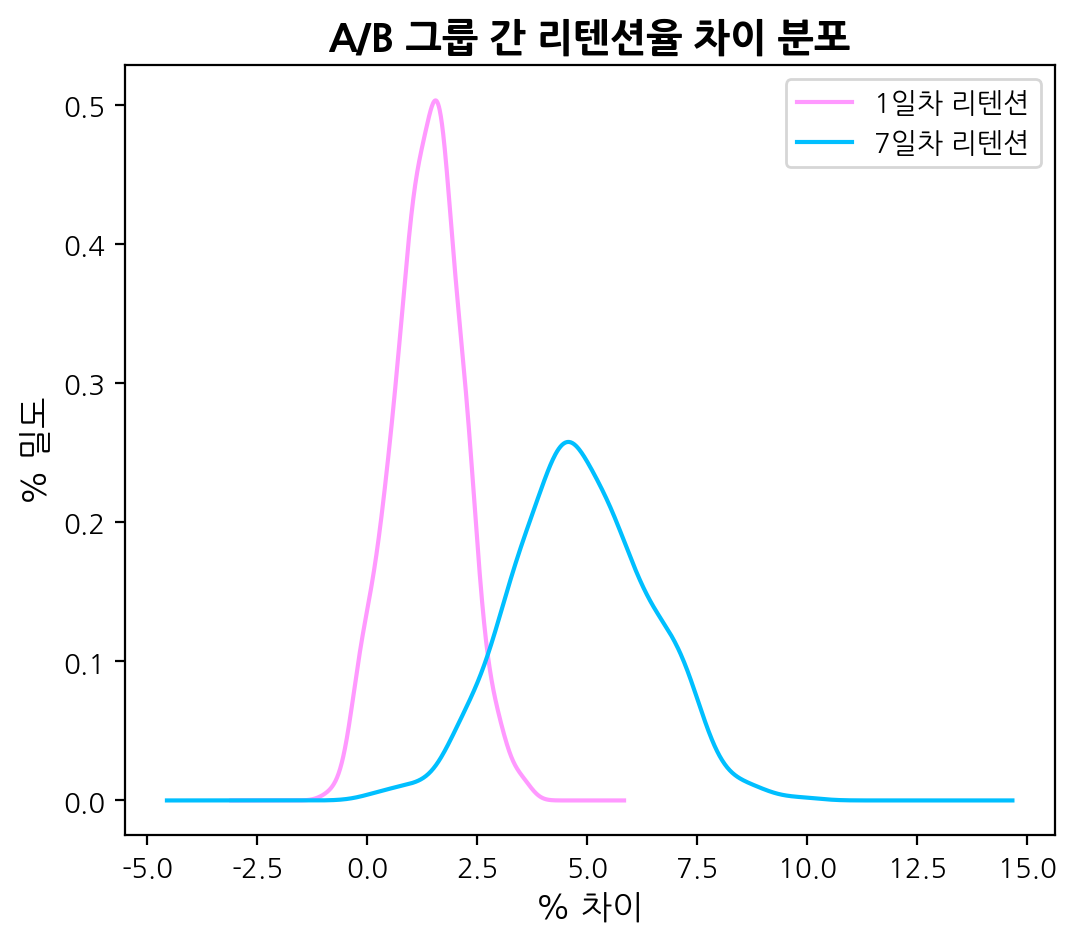

In [ ]:
boot_1d['diff'] = ((boot_1d['A'] - boot_1d['B']) / boot_1d['B'] * 100)
boot_7d['diff'] = ((boot_7d['A'] - boot_7d['B']) / boot_7d['B'] * 100)

fig, (ax1) = plt.subplots(1, 1, figsize=(6, 5))

boot_1d['diff'].plot.kde(ax=ax1, c="#ff99ff", label="1일차 리텐션")

boot_7d['diff'].plot.kde(ax=ax1, c="#00bfff", label="7일차 리텐션")

ax1.set_xlabel("% 차이", size=12)
ax1.set_ylabel("% 밀도", size=12)
ax1.set_title("A/B 그룹 간 리텐션율 차이 분포", fontweight="bold", size=14)

plt.legend()
plt.show()

### A/B 그룹 간 리텐션 비율 상대 차이 산출

In [ ]:
prob_1 = (boot_1d['diff'] > 0).sum() / len(boot_1d['diff'])

prob_7 = (boot_7d['diff'] > 0).sum() / len(boot_7d['diff'])

print(f"게이트가 30레벨일 때 1일차 리텐션이 더 높을 확률: {round(prob_1, 2) * 100}% \
      \n게이트가 30레벨일 때 7일차 리텐션이 더 높을 확률: {round(prob_7 * 100, 2)}%")

게이트가 30레벨일 때 1일차 리텐션이 더 높을 확률: 95.0%       
게이트가 30레벨일 때 7일차 리텐션이 더 높을 확률: 100.0%


## 카이제곱 0 불포함

In [ ]:
df = pd.read_csv("cookie_cats.csv")
lower_limit = df['sum_gamerounds'].quantile(0.01)
upper_limit = df['sum_gamerounds'].quantile(0.99)
df = df[(df['sum_gamerounds'] >= lower_limit) & (df['sum_gamerounds'] <= upper_limit)]

### 게임 버전과 1일 리텐션의 독립성 검정 (전체 사용자) & 1일 리텐션 카이제곱 검정의 기대 빈도표 확인 (전체 사용자)

In [ ]:
contingency = pd.crosstab(df['version'], df['retention_1'])
chi2, p, dof, expected = chi2_contingency(contingency)

print('카이제곱 통계량:', chi2)
print('p-value:', p)
print('자유도:', dof)

if p < 0.05 :
  print('통계적으로 유의미한 차이가 있음')
else :
  print('통계적으로 유의미한 차이가 없음')

index = ['gate_30', 'gate_40']

contingency_df = pd.DataFrame(expected, index = index)

contingency_df.columns.name = 'retention_1'
print('기대 빈도표')
print(contingency_df)

카이제곱 통계량: 3.2511381280488836
p-value: 0.07137388196755491
자유도: 1
통계적으로 유의미한 차이가 없음
기대 빈도표
retention_1             0             1
gate_30      24787.215979  19466.784021
gate_40      25225.784021  19811.215979


### 게임 버전과 7일 리텐션의 독립성 검정 (전체 사용자) & 7일 리텐션 카이제곱 검정의 기대 빈도표 확인 (전체 사용자)

In [ ]:
contingency = pd.crosstab(df['version'], df['retention_7'])

chi2, p, dof, expected = chi2_contingency(contingency)

print('카이제곱 통계량:', chi2)
print('p-value:', p)
print('자유도:', dof)

if p < 0.05 :
  print('통계적으로 유의미한 차이가 있음')
else :
  print('통계적으로 유의미한 차이가 없음')

index = ['gate_30', 'gate_40']

contingency_df = pd.DataFrame(expected, index = index)

contingency_df.columns.name = 'retention_7'
print('기대 빈도표')
print(contingency_df)

카이제곱 통계량: 10.556773743285333
p-value: 0.001157630723934999
자유도: 1
통계적으로 유의미한 차이가 있음
기대 빈도표
retention_7             0            1
gate_30      36362.315037  7891.684963
gate_40      37005.684963  8031.315037


## 카이제곱 검정 0 포함


In [ ]:
df = pd.read_csv("cookie_cats.csv")
lower_limit = df['sum_gamerounds'].quantile(0.01)
upper_limit = df['sum_gamerounds'].quantile(0.99)
df = df[(df['sum_gamerounds'] >= lower_limit) & (df['sum_gamerounds'] <= upper_limit)]

<Axes: xlabel='version', ylabel='sum_gamerounds'>

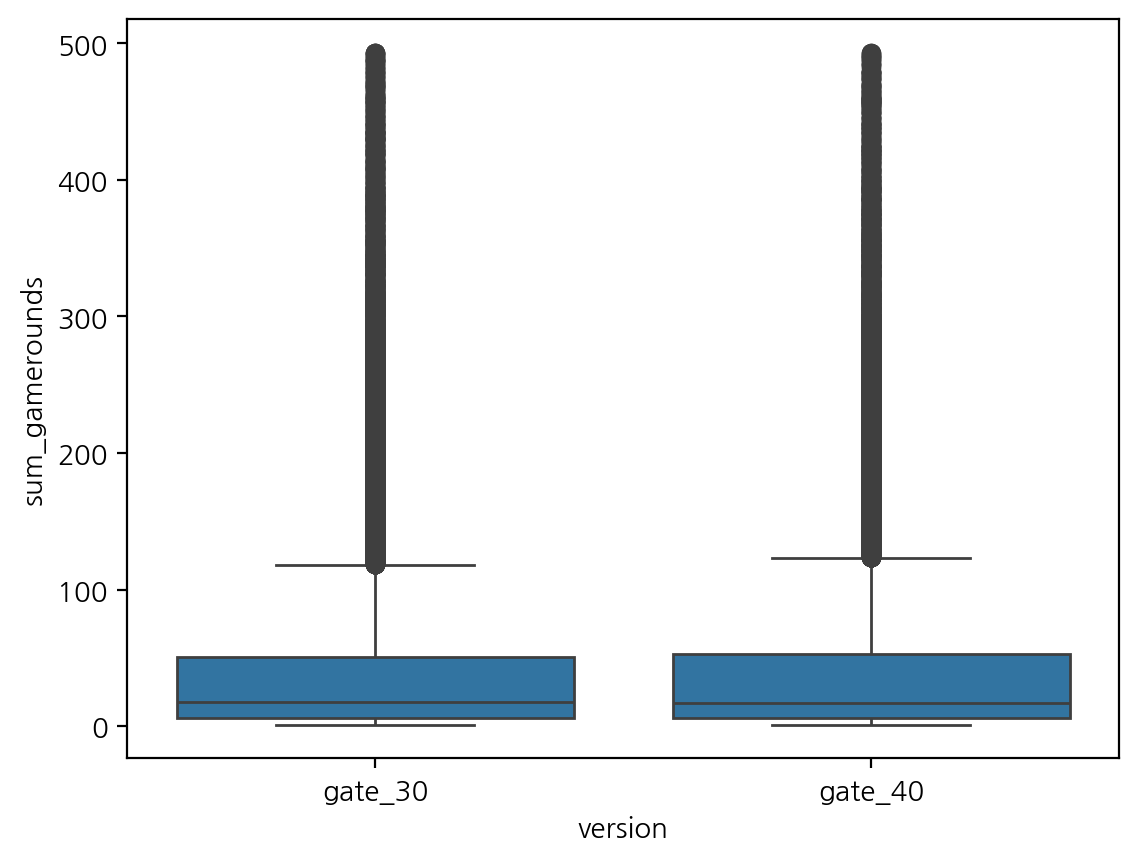

In [ ]:
play_user_df = df[df['sum_gamerounds']>0]
sns.boxplot(x='version', y = 'sum_gamerounds', data = play_user_df)

### 게임 버전과 1일 리텐션의 독립성 검정 (플레이 사용자만) & 1일 리텐션 카이제곱 검정의 기대 빈도표 확인 (플레이 사용자만)

In [ ]:
contingency = pd.crosstab(play_user_df['version'], play_user_df['retention_1'])

chi2, p, dof, expected = chi2_contingency(contingency)

print('카이제곱 통계량:', chi2)
print('p-value:', p)
print('자유도:', dof)
print('기대 빈도표')
print(expected)

if p < 0.05 :
  print('통계적으로 유의미한 차이가 있음')
else :
  print('통계적으로 유의미한 차이가 없음')

index = ['gate_30', 'gate_40']

contingency_df = pd.DataFrame(expected, index = index)

contingency_df.columns.name = 'retention_1'

print(contingency_df)

카이제곱 통계량: 2.554644555016835
p-value: 0.10997054465977232
자유도: 1
기대 빈도표
[[22873.8127015 19443.1872985]
 [23232.1872985 19747.8127015]]
통계적으로 유의미한 차이가 없음
retention_1             0             1
gate_30      22873.812702  19443.187298
gate_40      23232.187298  19747.812702


### 게임 버전과 7일 리텐션의 독립성 검정 (플레이 사용자만) & 7일 리텐션 카이제곱 검정의 기대 빈도표 확인 (플레이 사용자만)

In [ ]:
contingency = pd.crosstab(play_user_df['version'], play_user_df['retention_7'])

chi2, p, dof, expected = chi2_contingency(contingency)

print('카이제곱 통계량:', chi2)
print('p-value:', p)
print('자유도:', dof)

if p < 0.05 :
  print('통계적으로 유의미한 차이가 있음')
else :
  print('통계적으로 유의미한 차이가 없음')

index = ['gate_30', 'gate_40']

contingency_df = pd.DataFrame(expected, index = index)

contingency_df.columns.name = 'retention_7'
print('기대 빈도표')
print(contingency_df)

카이제곱 통계량: 9.611011953238634
p-value: 0.001934140315170838
자유도: 1
통계적으로 유의미한 차이가 있음
기대 빈도표
retention_7             0            1
gate_30      34431.770766  7885.229234
gate_40      34971.229234  8008.770766


## 부트스트랩 신뢰구간(Bootstrap CI)

### 1일 리텐션 평균 차이 (gate_40 − gate_30)

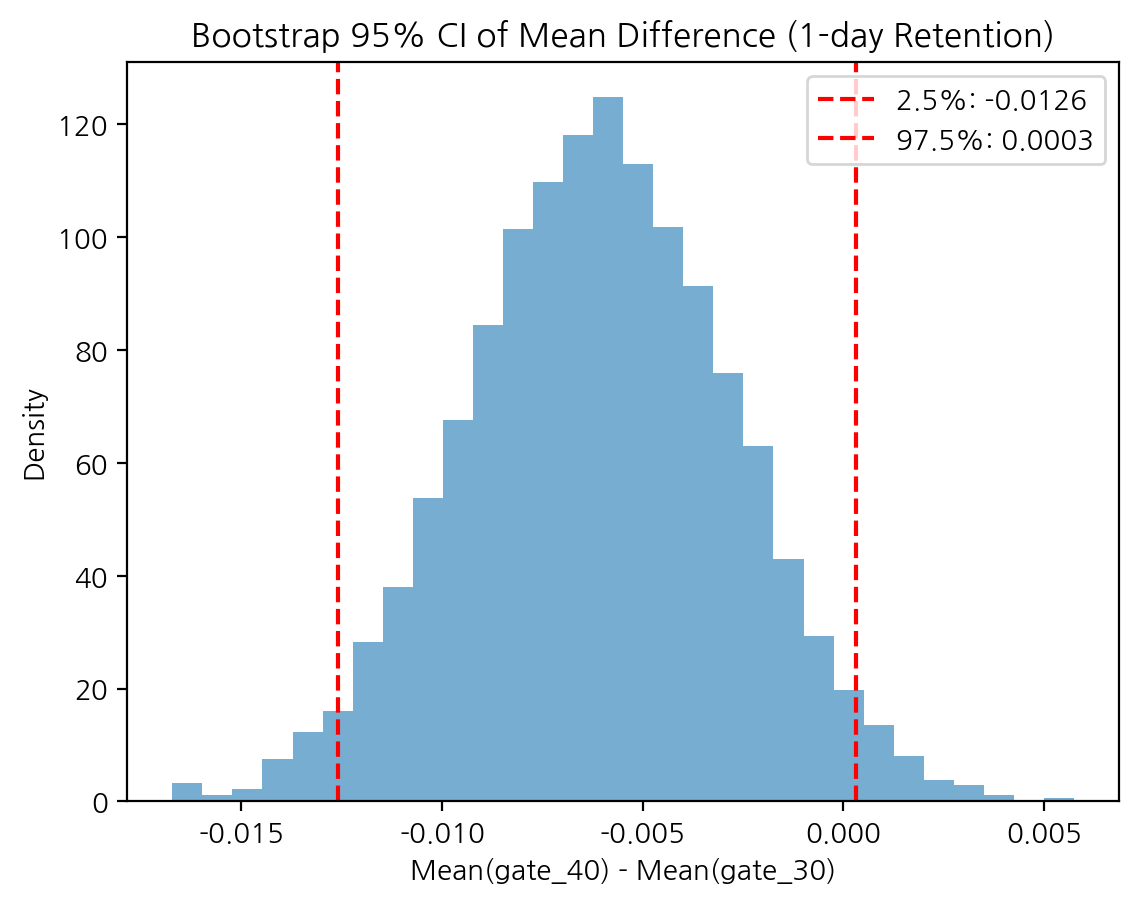

Observed difference: -0.0060
Bootstrap 95% CI: [-0.0126, 0.0003]


In [ ]:
metric = 'retention_1'
values_A = df[df.version=='gate_30'][metric].values
values_B = df[df.version=='gate_40'][metric].values

n_boot = 5000
boot_diffs = np.empty(n_boot)

for i in range(n_boot):
    sample_A = np.random.choice(values_A, size=len(values_A), replace=True)
    sample_B = np.random.choice(values_B, size=len(values_B), replace=True)
    boot_diffs[i] = sample_B.mean() - sample_A.mean()

ci_lower, ci_upper = np.percentile(boot_diffs, [2.5, 97.5])

plt.figure()
plt.hist(boot_diffs, bins=30, density=True, alpha=0.6)
plt.axvline(ci_lower, color='red', linestyle='--', label=f'2.5%: {ci_lower:.4f}')
plt.axvline(ci_upper, color='red', linestyle='--', label=f'97.5%: {ci_upper:.4f}')
plt.title('Bootstrap 95% CI of Mean Difference (1-day Retention)')
plt.xlabel('Mean(gate_40) - Mean(gate_30)')
plt.ylabel('Density')
plt.legend()
plt.show()

obs_diff = values_B.mean() - values_A.mean()
print(f"Observed difference: {obs_diff:.4f}")
print(f"Bootstrap 95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]")

### 7일 리텐션 평균 차이 (gate_40 − gate_30)

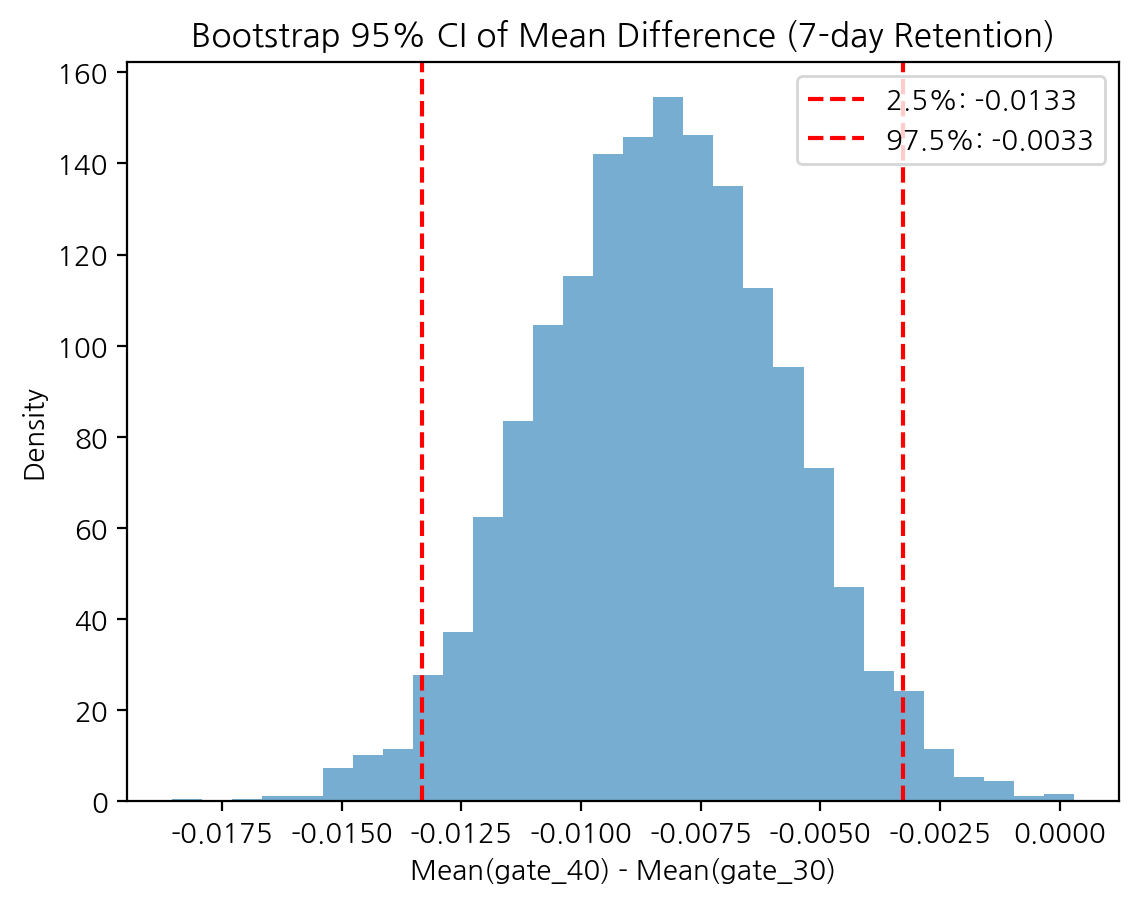

Observed difference: -0.0083
Bootstrap 95% CI: [-0.0133, -0.0033]


In [ ]:
metric = 'retention_7'
values_A = df[df.version=='gate_30'][metric].values
values_B = df[df.version=='gate_40'][metric].values

n_boot = 5000
boot_diffs = np.empty(n_boot)

for i in range(n_boot):
    sample_A = np.random.choice(values_A, size=len(values_A), replace=True)
    sample_B = np.random.choice(values_B, size=len(values_B), replace=True)
    boot_diffs[i] = sample_B.mean() - sample_A.mean()

ci_lower, ci_upper = np.percentile(boot_diffs, [2.5, 97.5])

plt.figure()
plt.hist(boot_diffs, bins=30, density=True, alpha=0.6)
plt.axvline(ci_lower, color='red', linestyle='--', label=f'2.5%: {ci_lower:.4f}')
plt.axvline(ci_upper, color='red', linestyle='--', label=f'97.5%: {ci_upper:.4f}')
plt.title('Bootstrap 95% CI of Mean Difference (7-day Retention)')
plt.xlabel('Mean(gate_40) - Mean(gate_30)')
plt.ylabel('Density')
plt.legend()
plt.show()

obs_diff = values_B.mean() - values_A.mean()
print(f"Observed difference: {obs_diff:.4f}")
print(f"Bootstrap 95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]")

## Cliff's Delta

In [ ]:
df = pd.read_csv("cookie_cats.csv")
lower_limit = df['sum_gamerounds'].quantile(0.01)
upper_limit = df['sum_gamerounds'].quantile(0.99)
df = df[(df['sum_gamerounds'] >= lower_limit) & (df['sum_gamerounds'] <= upper_limit)]

In [ ]:
df["version"] = np.where(df["version"] == "gate_30", "A", "B")

### 1일 리텐션의 Cliff’s Delta (A vs B)

In [ ]:
group_A = df[df['version'] == 'A']['retention_1'].values
group_B = df[df['version'] == 'B']['retention_1'].values

delta, magnitude = cliffs_delta(group_A, group_B)

print(f"Cliff's Delta: {delta:.4f}")
print(f"효과 크기 해석: {magnitude}")

Cliff's Delta: 0.0060
효과 크기 해석: negligible


### 7일 리텐션의 Cliff’s Delta (A vs B)

In [ ]:
group_A = df[df['version'] == 'A']['retention_7'].values
group_B = df[df['version'] == 'B']['retention_7'].values

delta, magnitude = cliffs_delta(group_A, group_B)

print(f"Cliff's Delta: {delta:.4f}")
print(f"효과 크기 해석: {magnitude}")

Cliff's Delta: 0.0083
효과 크기 해석: negligible


## two-proportion Z-Test


In [ ]:
df = pd.read_csv("cookie_cats.csv")
lower_limit = df['sum_gamerounds'].quantile(0.01)
upper_limit = df['sum_gamerounds'].quantile(0.99)
df = df[(df['sum_gamerounds'] >= lower_limit) & (df['sum_gamerounds'] <= upper_limit)]

In [ ]:
df["version"] = np.where(df["version"] == "gate_30", "A", "B")

### 1일 리텐션 Two-proportion Z-test (A vs B)

In [ ]:
group_A = df[df['version'] == 'A']['retention_1']
group_B = df[df['version'] == 'B']['retention_1']

success = [group_A.sum(), group_B.sum()]

nobs = [group_A.count(), group_B.count()]

z_stat, pval = proportions_ztest(success, nobs)

In [ ]:
print("Z 통계량:", z_stat)
print("p-value:", pval)

if pval < 0.05:
    print("귀무가설 기각: 두 그룹의 리텐션율은 유의하게 다릅니다.")
else:
    print("귀무가설 채택: 두 그룹의 리텐션율은 통계적으로 유사합니다.")

Z 통계량: 1.8098335131034136
p-value: 0.07032160914438722
귀무가설 채택: 두 그룹의 리텐션율은 통계적으로 유사합니다.


### 7일 리텐션 Two-proportion Z-test (A vs B)

In [ ]:
group_A = df[df['version'] == 'A']['retention_7']
group_B = df[df['version'] == 'B']['retention_7']

success = [group_A.sum(), group_B.sum()]

nobs = [group_A.count(), group_B.count()]

z_stat, pval = proportions_ztest(success, nobs)

In [ ]:
print("Z 통계량:", z_stat)
print("p-value:", pval)

if pval < 0.05:
    print("귀무가설 기각: 두 그룹의 리텐션율은 유의하게 다릅니다.")
else:
    print("귀무가설 채택: 두 그룹의 리텐션율은 통계적으로 유사합니다.")

Z 통계량: 3.25786180276105
p-value: 0.001122550593303269
귀무가설 기각: 두 그룹의 리텐션율은 유의하게 다릅니다.


## 순열 검정

### 1일 리텐션 평균 차이 유의성 평가, 순열 분포 시각화 및 p-value 계산

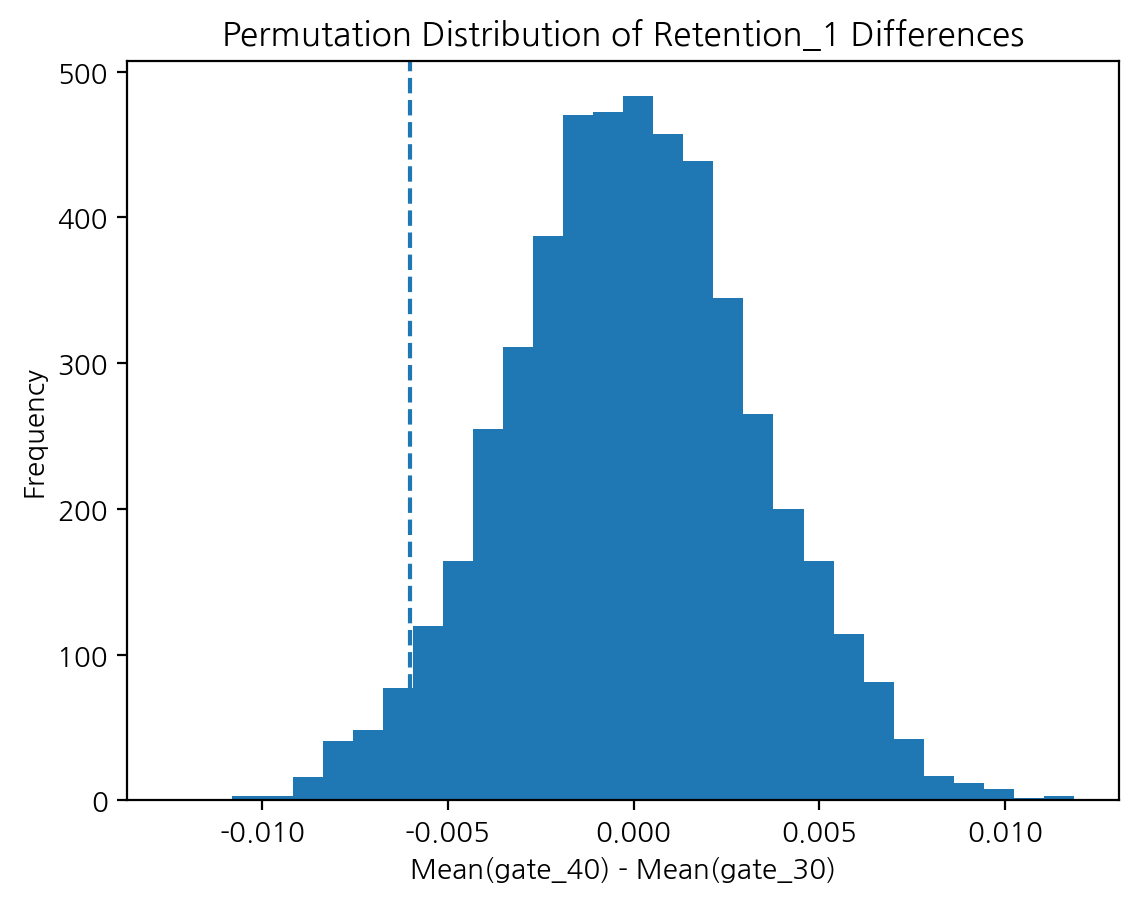

Observed difference (gate_40 - gate_30): -0.0060
Permutation test p-value: 0.0750


In [ ]:
df = pd.read_csv('cookie_cats.csv')
lower_limit = df['sum_gamerounds'].quantile(0.01)
upper_limit = df['sum_gamerounds'].quantile(0.99)
df = df[(df['sum_gamerounds'] >= lower_limit) & (df['sum_gamerounds'] <= upper_limit)]

group_col = 'version'
target_col = 'retention_1'

groupA = df[df[group_col] == 'gate_30'][target_col].values
groupB = df[df[group_col] == 'gate_40'][target_col].values

obs_diff = np.mean(groupB) - np.mean(groupA)

combined = np.concatenate([groupA, groupB])
n_permutations = 5000
perm_diffs = np.empty(n_permutations)

for i in range(n_permutations):
    permuted = np.random.permutation(combined)
    newA = permuted[:len(groupA)]
    newB = permuted[len(groupA):]
    perm_diffs[i] = np.mean(newB) - np.mean(newA)

p_value = np.mean(np.abs(perm_diffs) >= np.abs(obs_diff))

plt.figure()
plt.hist(perm_diffs, bins=30)
plt.axvline(obs_diff, linestyle='--')
plt.title('Permutation Distribution of Retention_1 Differences')
plt.xlabel('Mean(gate_40) - Mean(gate_30)')
plt.ylabel('Frequency')
plt.show()

print(f"Observed difference (gate_40 - gate_30): {obs_diff:.4f}")
print(f"Permutation test p-value: {p_value:.4f}")

### 7일 리텐션 평균 차이 유의성 평가, 순열 분포 시각화 및 p-value 계산

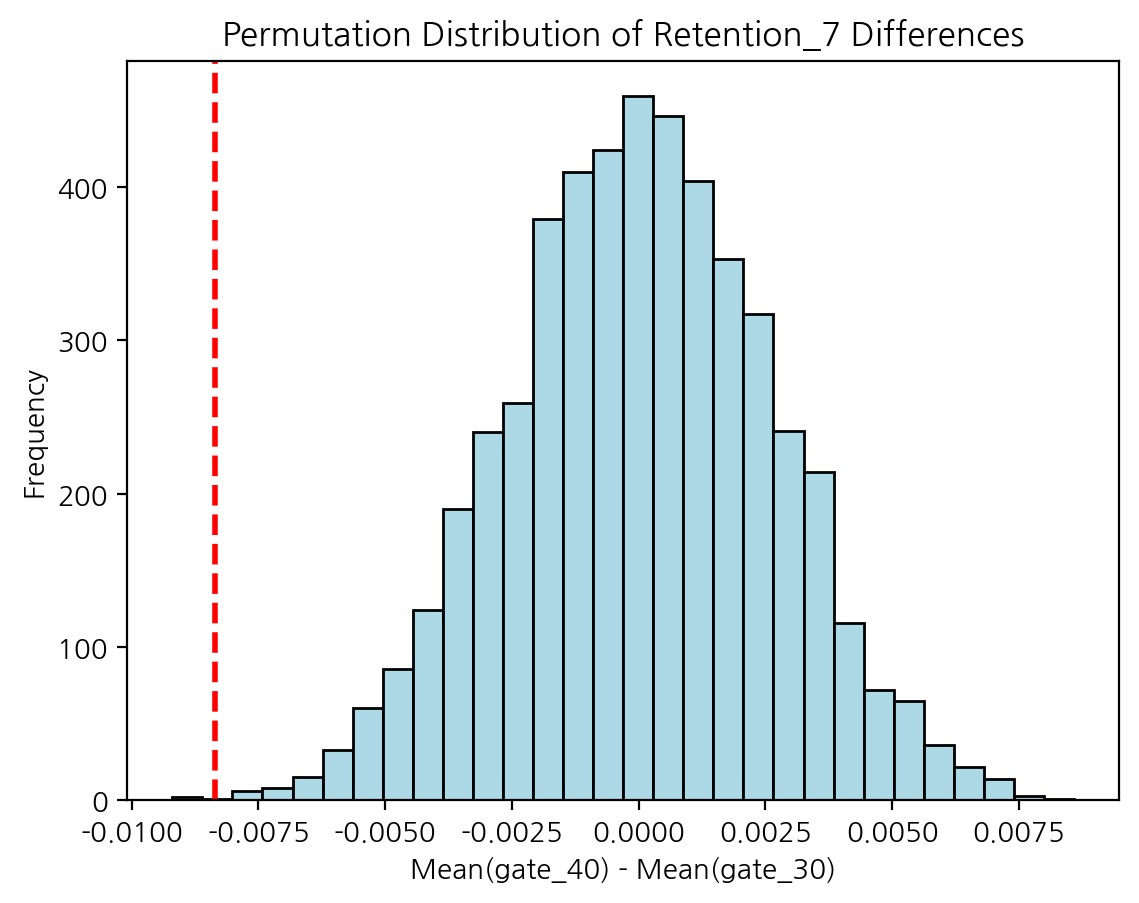

Observed difference (gate_40 - gate_30): -0.0083
Permutation test p-value: 0.0008


In [ ]:
df = pd.read_csv('cookie_cats.csv')
lower_limit = df['sum_gamerounds'].quantile(0.01)
upper_limit = df['sum_gamerounds'].quantile(0.99)
df = df[(df['sum_gamerounds'] >= lower_limit) & (df['sum_gamerounds'] <= upper_limit)]

group_col = 'version'
target_col = 'retention_7'

groupA = df[df[group_col] == 'gate_30'][target_col].values
groupB = df[df[group_col] == 'gate_40'][target_col].values

obs_diff = np.mean(groupB) - np.mean(groupA)

combined = np.concatenate([groupA, groupB])
n_permutations = 5000
perm_diffs = np.empty(n_permutations)

for i in range(n_permutations):
    permuted = np.random.permutation(combined)
    newA = permuted[:len(groupA)]
    newB = permuted[len(groupA):]
    perm_diffs[i] = np.mean(newB) - np.mean(newA)

p_value = np.mean(np.abs(perm_diffs) >= np.abs(obs_diff))

plt.figure()
plt.hist(perm_diffs, bins=30, color='lightblue', edgecolor='black')
plt.axvline(obs_diff, color='red', linestyle='--', linewidth=2)
plt.title('Permutation Distribution of Retention_7 Differences')
plt.xlabel('Mean(gate_40) - Mean(gate_30)')
plt.ylabel('Frequency')
plt.show()

print(f"Observed difference (gate_40 - gate_30): {obs_diff:.4f}")
print(f"Permutation test p-value: {p_value:.4f}")

## 순차검정


### 1일 리텐션 중간 분석 및 조기 종료 판단

In [ ]:
df = pd.read_csv('cookie_cats.csv')
lower_limit = df['sum_gamerounds'].quantile(0.01)
upper_limit = df['sum_gamerounds'].quantile(0.99)
df = df[(df['sum_gamerounds'] >= lower_limit) & (df['sum_gamerounds'] <= upper_limit)]

alpha = 0.05
looks = [0.2, 0.4, 0.6, 0.8, 1.0]
n = len(df)
sample_sizes = [int(n * p) for p in looks]

alpha_threshold = alpha / len(looks)

np.random.seed(42)
shuffled = df.sample(frac=1).reset_index(drop=True)

results = []
for i, size in enumerate(sample_sizes, start=1):
    sub = shuffled.iloc[:size]
    A = sub[sub.version == 'gate_30']['retention_1']
    B = sub[sub.version == 'gate_40']['retention_1']
    stat, p_val = mannwhitneyu(A, B, alternative='two-sided')
    stop = (p_val < alpha_threshold)

    results.append({
        'Look':       i,
        'Samples':    size,
        'p-value':    round(p_val, 4),
        'Threshold':  round(alpha_threshold, 4),
        'Stop Early': stop
    })

results_df = pd.DataFrame(results)
print(results_df)

   Look  Samples  p-value  Threshold  Stop Early
0     1    17858   0.0748       0.01       False
1     2    35716   0.0838       0.01       False
2     3    53574   0.1176       0.01       False
3     4    71432   0.0801       0.01       False
4     5    89291   0.0703       0.01       False


### 7일 리텐션 중간 분석 및 조기 종료 판단

In [ ]:
df = pd.read_csv('cookie_cats.csv')
lower_limit = df['sum_gamerounds'].quantile(0.01)
upper_limit = df['sum_gamerounds'].quantile(0.99)
df = df[(df['sum_gamerounds'] >= lower_limit) & (df['sum_gamerounds'] <= upper_limit)]

alpha = 0.05
looks = [0.2, 0.4, 0.6, 0.8, 1.0]
n = len(df)
sample_sizes = [int(n * p) for p in looks]

alpha_threshold = alpha / len(looks)

np.random.seed(42)
shuffled = df.sample(frac=1).reset_index(drop=True)

results = []
for i, size in enumerate(sample_sizes, start=1):
    sub = shuffled.iloc[:size]
    A = sub[sub.version == 'gate_30']['retention_7']
    B = sub[sub.version == 'gate_40']['retention_7']
    stat, p_val = mannwhitneyu(A, B, alternative='two-sided')
    stop = (p_val < alpha_threshold)

    results.append({
        'Look':       i,
        'Samples':    size,
        'p-value':    round(p_val, 4),
        'Threshold':  round(alpha_threshold,4),
        'Stop Early': stop
    })

results_df = pd.DataFrame(results)
print(results_df)


   Look  Samples  p-value  Threshold  Stop Early
0     1    17858   0.2077       0.01       False
1     2    35716   0.0422       0.01       False
2     3    53574   0.0161       0.01       False
3     4    71432   0.0018       0.01        True
4     5    89291   0.0011       0.01        True


## 베이지안 A/B Test

###  1일 리텐션 사후분포 추정 및 우위 확률 계산

           sum  count
version              
gate_30  19601  44254
gate_40  19677  45037


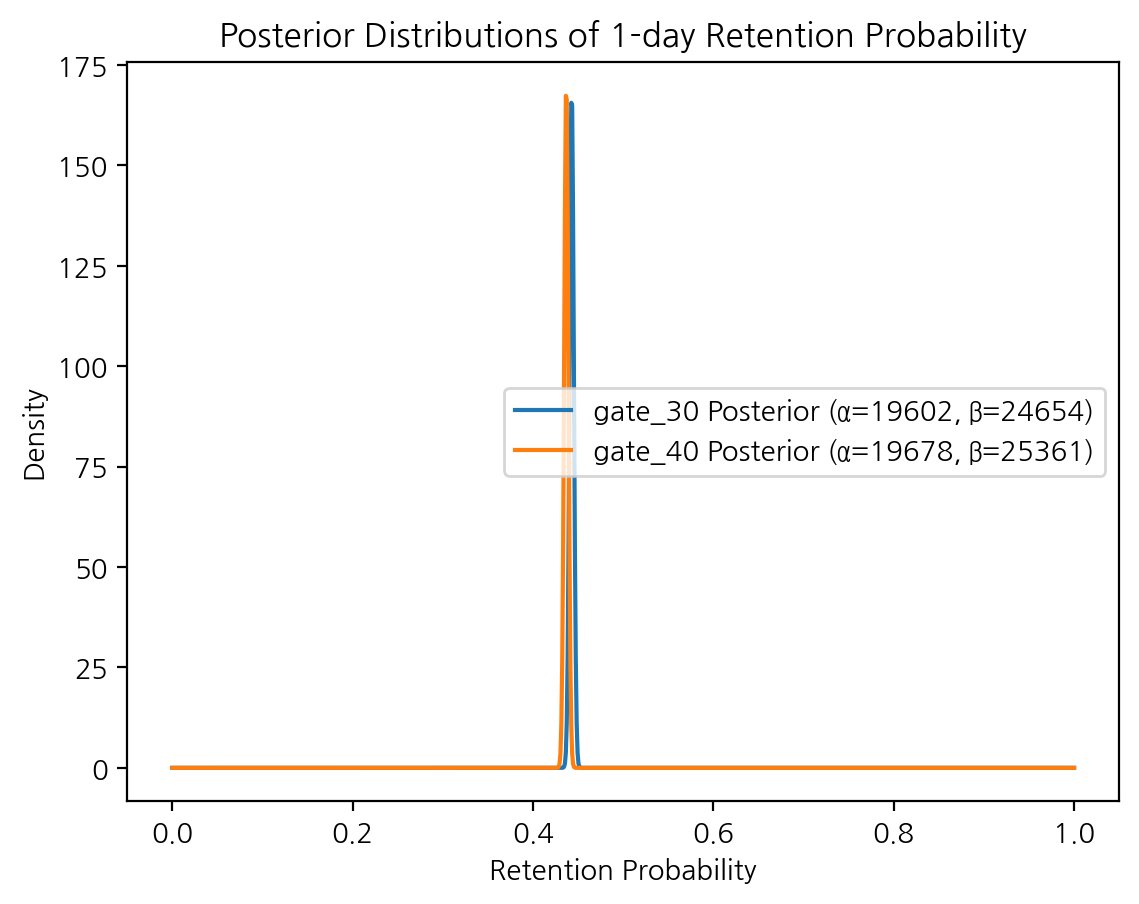

P(p_gate_40 > p_gate_30) = 0.0341


In [ ]:
df = pd.read_csv('cookie_cats.csv')
lower_limit = df['sum_gamerounds'].quantile(0.01)
upper_limit = df['sum_gamerounds'].quantile(0.99)
df = df[(df['sum_gamerounds'] >= lower_limit) & (df['sum_gamerounds'] <= upper_limit)]

group_col = 'version'
target_col = 'retention_1'

counts = df.groupby(group_col)[target_col].agg(['sum', 'count'])
print(counts)

successes = counts['sum']
trials = counts['count']
failures = trials - successes

alpha_prior, beta_prior = 1, 1

posterior_params = {
    grp: (alpha_prior + successes[grp], beta_prior + failures[grp])
    for grp in counts.index
}

n_samples = 20000
samples = {
    grp: np.random.beta(a, b, size=n_samples)
    for grp, (a, b) in posterior_params.items()
}

p_B_greater_A = np.mean(samples['gate_40'] > samples['gate_30'])

x = np.linspace(0, 1, 1000)
plt.figure()
for grp, (a, b) in posterior_params.items():
    plt.plot(x, beta.pdf(x, a, b), label=f"{grp} Posterior (α={a}, β={b})")
plt.title('Posterior Distributions of 1-day Retention Probability')
plt.xlabel('Retention Probability')
plt.ylabel('Density')
plt.legend()
plt.show()

print(f"P(p_gate_40 > p_gate_30) = {p_B_greater_A:.4f}")

### 1일 리텐션 차이의 사후분포와 ROPE 기반 판단

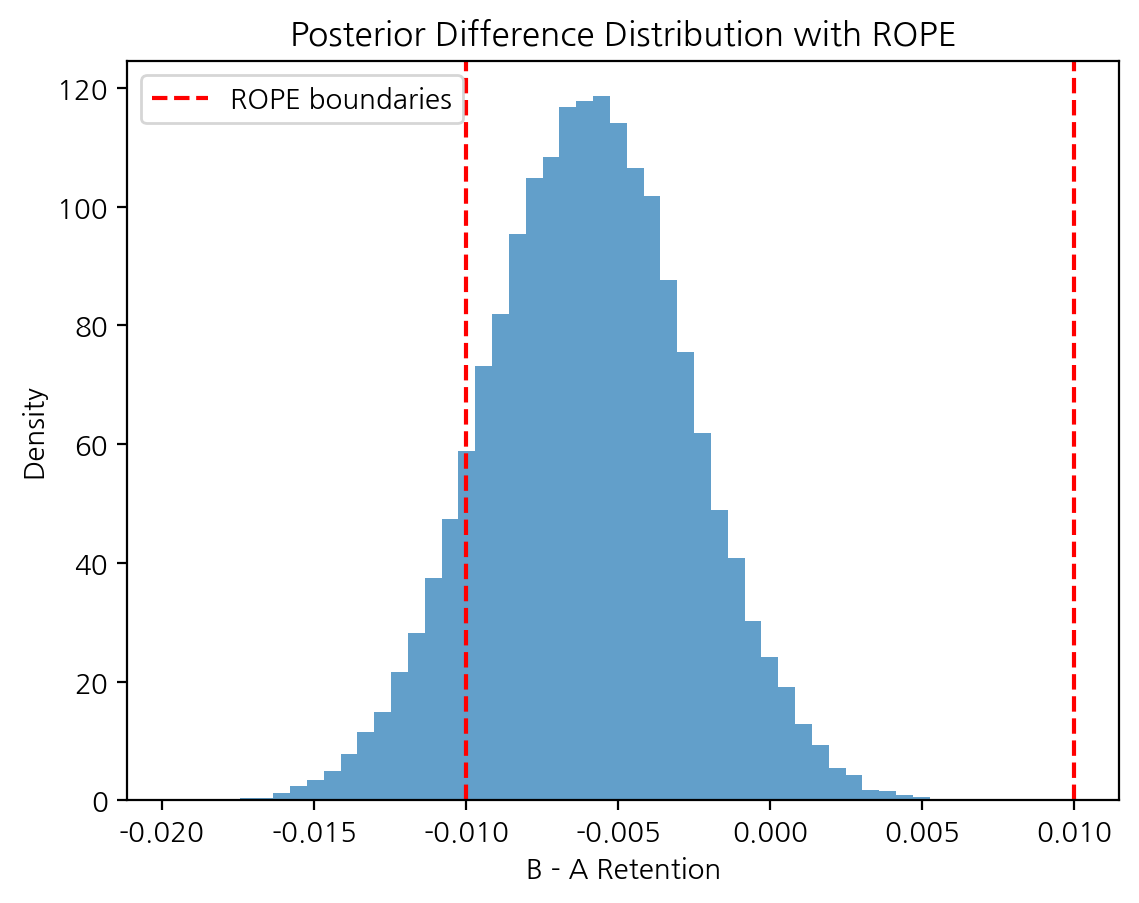

P(diff in ROPE (-0.01, 0.01)): 0.8856
P(B > A + ROPE): 0.0000
P(A > B + ROPE): 0.1144
0-1 Expected Loss: 0.0000
Weighted Expected Loss: 0.2288


In [ ]:
df = pd.read_csv('cookie_cats.csv')
lower_limit = df['sum_gamerounds'].quantile(0.01)
upper_limit = df['sum_gamerounds'].quantile(0.99)
df = df[(df['sum_gamerounds'] >= lower_limit) & (df['sum_gamerounds'] <= upper_limit)]

counts = df.groupby('version')['retention_1'].agg(['sum', 'count'])
successes = counts['sum']
trials = counts['count']
failures = trials - successes

alpha_prior, beta_prior = 1, 1

post_params = {
    grp: (alpha_prior + successes[grp], beta_prior + failures[grp])
    for grp in counts.index
}

n_samples = 50000
samples_A = np.random.beta(post_params['gate_30'][0], post_params['gate_30'][1], size=n_samples)
samples_B = np.random.beta(post_params['gate_40'][0], post_params['gate_40'][1], size=n_samples)
diff_samples = samples_B - samples_A

rope = (-0.01, 0.01)
p_in_rope = np.mean((diff_samples > rope[0]) & (diff_samples < rope[1]))
p_above_rope = np.mean(diff_samples > rope[1])
p_below_rope = np.mean(diff_samples < rope[0])

loss_01 = min(p_above_rope, p_below_rope)

loss_weighted = p_above_rope * 1 + p_below_rope * 2

plt.figure()
plt.hist(diff_samples, bins=50, density=True, alpha=0.7)
plt.axvline(rope[0], color='red', linestyle='--', label='ROPE boundaries')
plt.axvline(rope[1], color='red', linestyle='--')
plt.title('Posterior Difference Distribution with ROPE')
plt.xlabel('B - A Retention')
plt.ylabel('Density')
plt.legend()
plt.show()

print(f"P(diff in ROPE {rope}): {p_in_rope:.4f}")
print(f"P(B > A + ROPE): {p_above_rope:.4f}")
print(f"P(A > B + ROPE): {p_below_rope:.4f}")
print(f"0-1 Expected Loss: {loss_01:.4f}")
print(f"Weighted Expected Loss: {loss_weighted:.4f}")

###  7일 리텐션 사후분포 추정 및 우위 확률 계산

          sum  count
version             
gate_30  8078  44254
gate_40  7845  45037


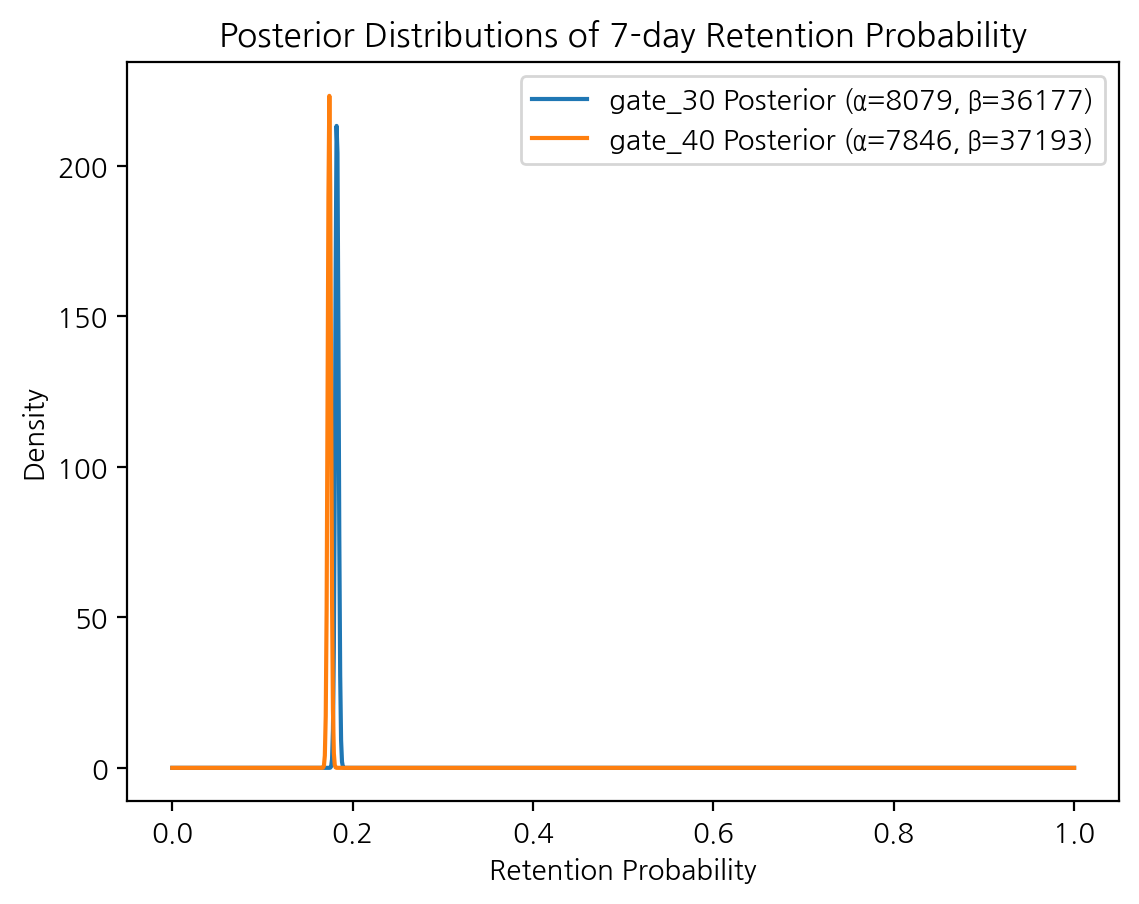

P(p_gate_40 > p_gate_30) = 0.0008


In [ ]:
df = pd.read_csv('cookie_cats.csv')
lower_limit = df['sum_gamerounds'].quantile(0.01)
upper_limit = df['sum_gamerounds'].quantile(0.99)
df = df[(df['sum_gamerounds'] >= lower_limit) & (df['sum_gamerounds'] <= upper_limit)]

group_col = 'version'
target_col = 'retention_7'

counts = df.groupby(group_col)[target_col].agg(['sum', 'count'])
print(counts)

successes = counts['sum']
trials = counts['count']
failures = trials - successes

alpha_prior, beta_prior = 1, 1

posterior_params = {
    grp: (alpha_prior + successes[grp], beta_prior + failures[grp])
    for grp in counts.index
}

n_samples = 20000
samples = {
    grp: np.random.beta(a, b, size=n_samples)
    for grp, (a, b) in posterior_params.items()
}

p_B_greater_A = np.mean(samples['gate_40'] > samples['gate_30'])

x = np.linspace(0, 1, 1000)
plt.figure()
for grp, (a, b) in posterior_params.items():
    plt.plot(x, beta.pdf(x, a, b), label=f"{grp} Posterior (α={a}, β={b})")
plt.title('Posterior Distributions of 7-day Retention Probability')
plt.xlabel('Retention Probability')
plt.ylabel('Density')
plt.legend()
plt.show()

print(f"P(p_gate_40 > p_gate_30) = {p_B_greater_A:.4f}")

### 7일 리텐션 차이의 사후분포와 ROPE 기반 판단

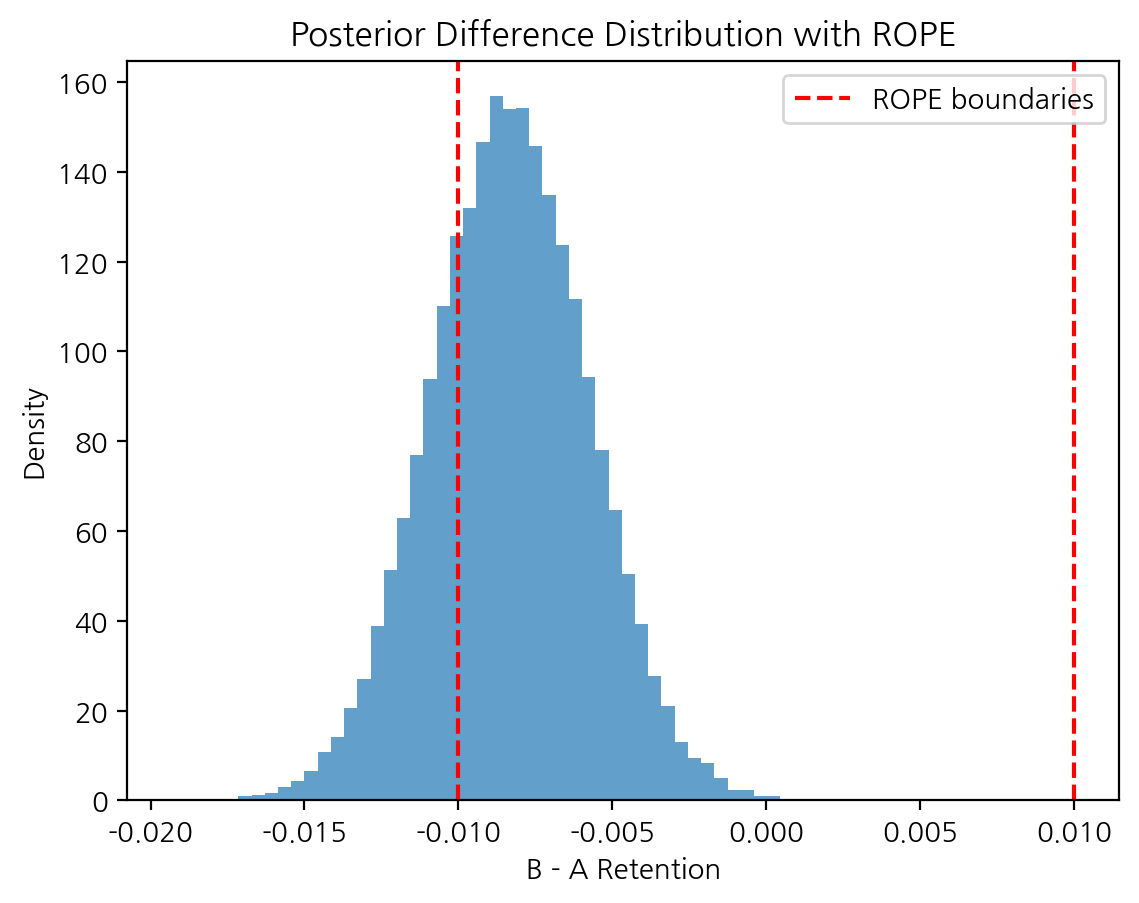

P(diff in ROPE (-0.01, 0.01)): 0.7402
P(B > A + ROPE): 0.0000
P(A > B + ROPE): 0.2598
0-1 Expected Loss: 0.0000
Weighted Expected Loss: 0.5196


In [ ]:
df = pd.read_csv('cookie_cats.csv')
lower_limit = df['sum_gamerounds'].quantile(0.01)
upper_limit = df['sum_gamerounds'].quantile(0.99)
df = df[(df['sum_gamerounds'] >= lower_limit) & (df['sum_gamerounds'] <= upper_limit)]

counts = df.groupby('version')['retention_7'].agg(['sum', 'count'])
successes = counts['sum']
trials = counts['count']
failures = trials - successes

alpha_prior, beta_prior = 1, 1

post_params = {
    grp: (alpha_prior + successes[grp], beta_prior + failures[grp])
    for grp in counts.index
}

n_samples = 50000
samples_A = np.random.beta(post_params['gate_30'][0], post_params['gate_30'][1], size=n_samples)
samples_B = np.random.beta(post_params['gate_40'][0], post_params['gate_40'][1], size=n_samples)
diff_samples = samples_B - samples_A

rope = (-0.01, 0.01)
p_in_rope = np.mean((diff_samples > rope[0]) & (diff_samples < rope[1]))
p_above_rope = np.mean(diff_samples > rope[1])
p_below_rope = np.mean(diff_samples < rope[0])

loss_01 = min(p_above_rope, p_below_rope)

loss_weighted = p_above_rope * 1 + p_below_rope * 2

plt.figure()
plt.hist(diff_samples, bins=50, density=True, alpha=0.7)
plt.axvline(rope[0], color='red', linestyle='--', label='ROPE boundaries')
plt.axvline(rope[1], color='red', linestyle='--')
plt.title('Posterior Difference Distribution with ROPE')
plt.xlabel('B - A Retention')
plt.ylabel('Density')
plt.legend()
plt.show()

print(f"P(diff in ROPE {rope}): {p_in_rope:.4f}")
print(f"P(B > A + ROPE): {p_above_rope:.4f}")
print(f"P(A > B + ROPE): {p_below_rope:.4f}")
print(f"0-1 Expected Loss: {loss_01:.4f}")
print(f"Weighted Expected Loss: {loss_weighted:.4f}")